# Evaluate mock community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of mock communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
from shutil import copytree

%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit repository. 
project_dir = join('..', '..')

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

In [3]:
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5', 'mock-7', 'mock-8', 'mock-9',
               'mock-10', 'mock-12', 'mock-16', 'mock-18', 'mock-19', 'mock-20', 'mock-21', 
               'mock-22', 'mock-23', 'mock-24', 'mock-26-ITS1', 'mock-26-ITS9']
reference_ids = ['gg_13_8_otus_full', 'gg_13_8_otus_amplicon', 'gg_13_8_otus_read',
                 'unite_20.11.2016_clean_full', 'unite_20.11.2016_clean_amplicon',
                 'unite_20.11.2016_clean_read']

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods to add, set `append=True`. If you are attempting to recompute pre-computed results, set `force=True`.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [4]:
for mock in dataset_ids:
    md = join(expected_results_dir, mock)
    if exists(join(md, 'gg_13_8_otus', 'expected')):
        src = join(md, 'gg_13_8_otus', 'expected')
        dsts = [join(md, 'gg_13_8_otus_full', 'expected'),
                join(md, 'gg_13_8_otus_amplicon', 'expected')]
        for dst in dsts:
            if not exists(dst):
                copytree(src, dst)
    elif exists(join(md, 'unite_20.11.2016_clean_fullITS', 'expected')):
        src = join(md, 'unite_20.11.2016_clean_fullITS', 'expected')
        dsts = [join(md, 'unite_20.11.2016_clean_full', 'expected'),
                join(md, 'unite_20.11.2016_clean_amplicon', 'expected')]
        for dst in dsts:
            if not exists(dst):
                copytree(src, dst)
    else:
        raise ValueError('no expected sequences for ' + mock)
        

In [5]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                dataset_ids=dataset_ids,
                                reference_ids=reference_ids,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                method_ids=['naive-bayes', 'naive-bayes-bespoke'],
                                append=False,
                                force=False)

../../data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True
Results have been filtered to only include datasets or reference databases or methods or parameters that are explicitly set by results params. To disable this function and load all results, set dataset_ids and reference_ids and method_ids and parameter_ids to None.


In [6]:
mock_results['Reference'].unique()

array(['gg_13_8_otus_amplicon', 'gg_13_8_otus_full',
       'unite_20.11.2016_clean_amplicon', 'unite_20.11.2016_clean_full'], dtype=object)

Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons. This can be performed as shown below — alternatively, specific reference databases, datasets, methods, or parameters can be chosen by setting dataset_ids, reference_ids, method_ids, and parameter_ids in the evaluate_results command above.

In [7]:
mock_results = filter_df(mock_results, column_name='Reference',
                         values=['gg_13_8_otus_amplicon', 'gg_13_8_otus_full',
                                 'unite_20.11.2016_clean_full'], exclude=False)

Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. **Higher scores = better accuracy**

As a first step, we will evaluate **average** method performance at each taxonomic level for each method within each reference dataset type.

**Note that, as parameter configurations can cause results to vary widely, average results are not a good representation of the "best" results. See [here](#Optimized-method-performance) for results using optimized parameters for each method.**

First we will define our [color palette](http://matplotlib.org/examples/color/named_colors.html) and the variables we want to plot. Via seaborn, we can apply the [xkcd crowdsourced color names](https://xkcd.com/color/rgb.txt). If that still doesn't match your hue, use hex codes.

In [8]:
color_pallette={
    'naive-bayes': 'blue', 'naive-bayes-bespoke': 'orange'
}

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

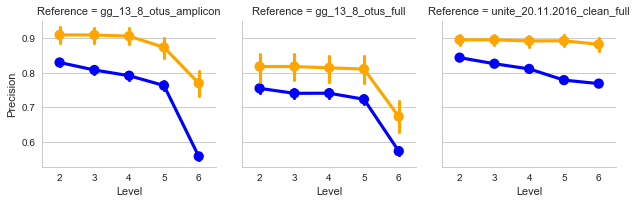

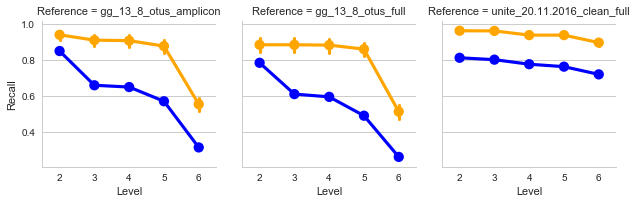

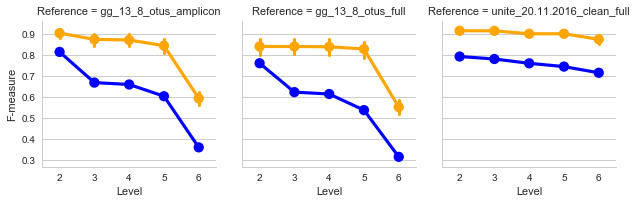

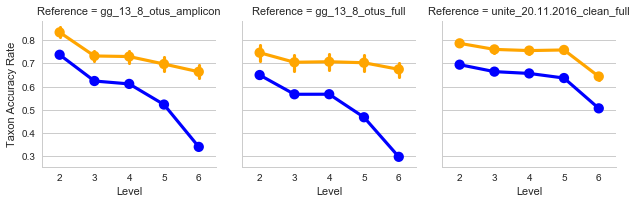

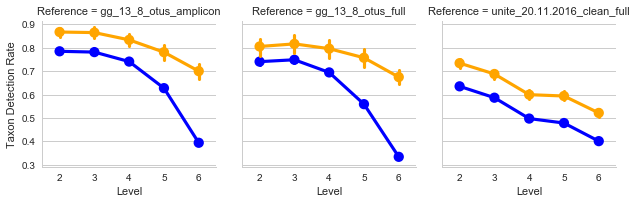

In [9]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [10]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Reference              Variable             2  \
0         gg_13_8_otus_amplicon             Precision  1.960670e-03   
1         gg_13_8_otus_amplicon                Recall  8.086396e-05   
2         gg_13_8_otus_amplicon             F-measure  4.042680e-03   
3         gg_13_8_otus_amplicon   Taxon Accuracy Rate  3.616809e-05   
4         gg_13_8_otus_amplicon  Taxon Detection Rate  4.403981e-02   
5             gg_13_8_otus_full             Precision  5.806095e-01   
6             gg_13_8_otus_full                Recall  6.507456e-29   
7             gg_13_8_otus_full             F-measure  4.736172e-13   
8             gg_13_8_otus_full   Taxon Accuracy Rate  2.844237e-11   
9             gg_13_8_otus_full  Taxon Detection Rate  5.464334e-02   
10  unite_20.11.2016_clean_full             Precision  1.926170e-01   
11  unite_20.11.2016_clean_full                Recall  1.134852e-11   
12  unite_20.11.2016_clean_full             F-measure  2.299182e-08   
13  unite_20.11.2016_clean_full   Taxon Accuracy Rate  8.734955e-10   
14  unite_20.11.2016_clean_full  Taxon Detection Rate  2.309001e-10   

               3             4             5             6  
0   1.019334e-05  6.739288e-05  5.031753e-06  1.615352e-32  
1   1.286304e-28  7.241147e-42  4.458385e-66  3.492438e-35  
2   4.623718e-36  3.097654e-37  1.766276e-51  8.671458e-39  
3   2.455151e-11  5.498455e-12  4.232587e-42  1.390476e-85  
4   4.440301e-02  6.512317e-08  2.687402e-36  2.417777e-86  
5   5.819929e-02  2.460518e-01  1.314067e-03  4.119984e-10  
6   1.120827e-38  3.117530e-51  4.311157e-70  3.664723e-37  
7   5.366400e-35  9.959653e-40  6.215868e-58  1.896108e-36  
8   3.152589e-26  2.486038e-27  4.498244e-66  1.972071e-91  
9   4.403981e-02  8.942429e-15  5.535279e-41  8.171599e-83  
10  5.798501e-04  1.803638e-04  2.734875e-06  3.845802e-11  
11  8.110902e-12  1.085118e-11  5.551952e-12  5.531389e-43  
12  6.341756e-09  4.873023e-10  8.483605e-10  1.190454e-29  
13  2.543535e-10  1.932514e-10  4.503136e-13  9.051197e-26  
14  4.226215e-11  2.185211e-13  1.543458e-16  3.599178e-27

### Heatmaps of per-level accuracy
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal mock communities individually).

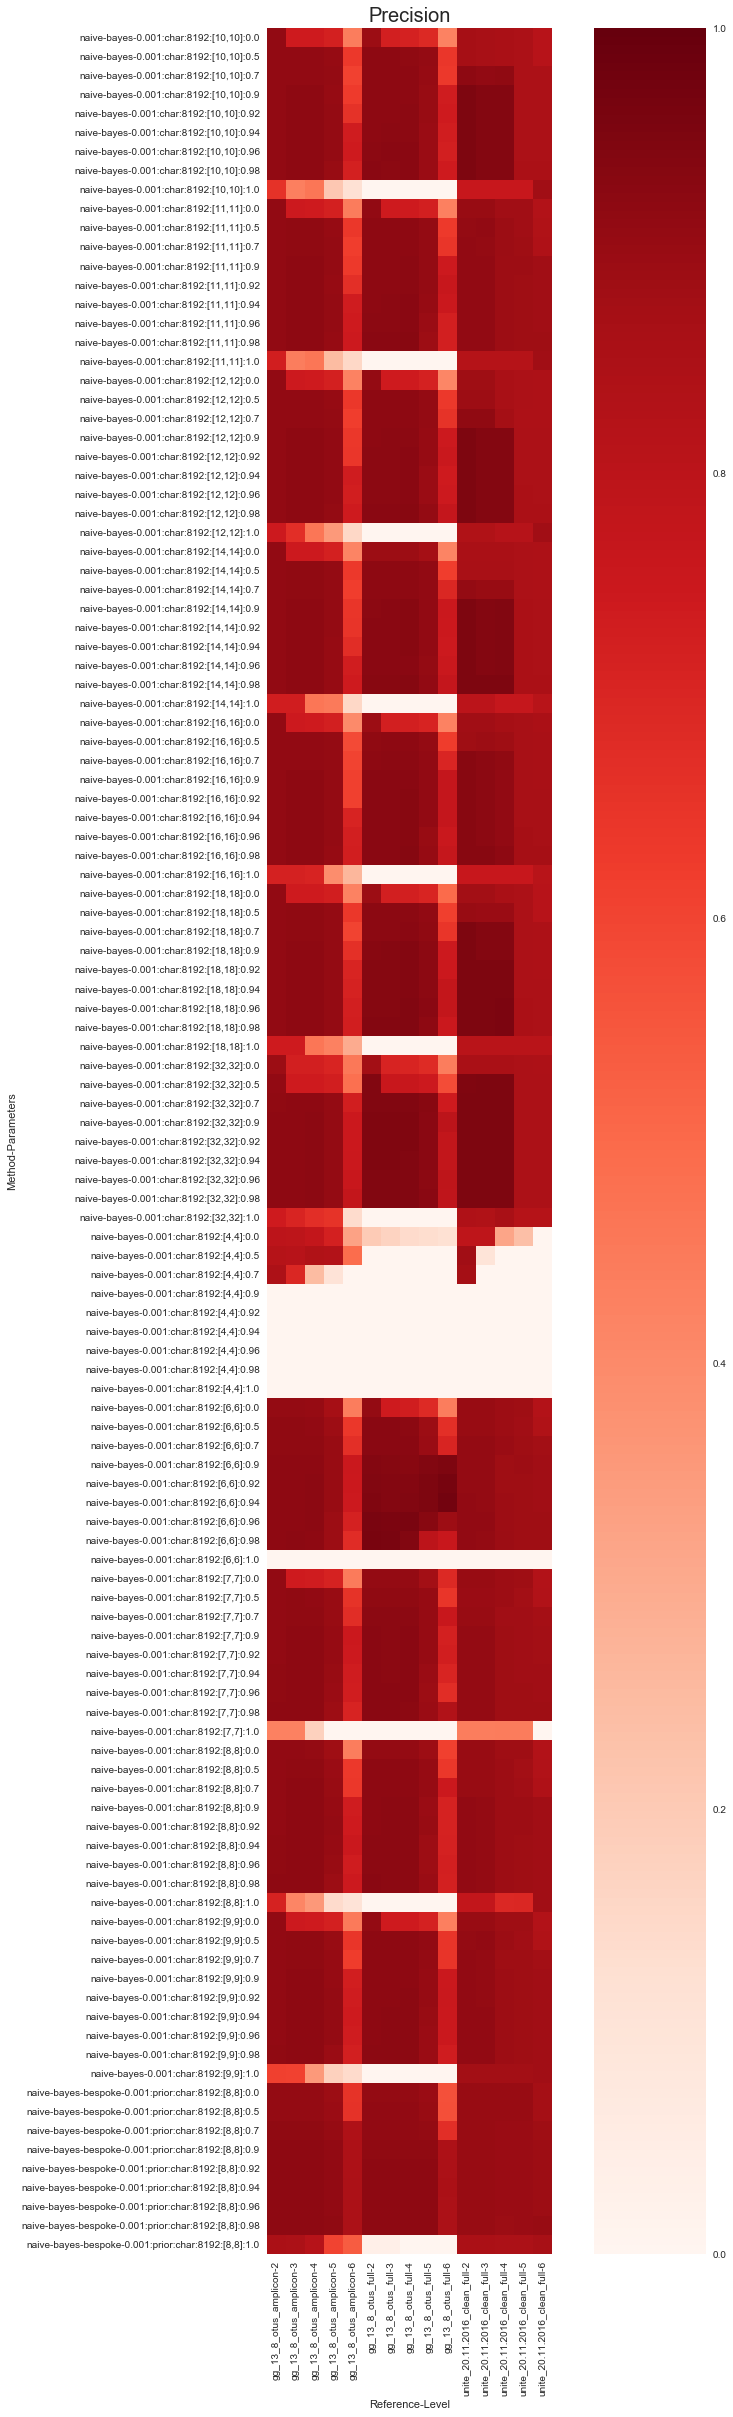

In [11]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

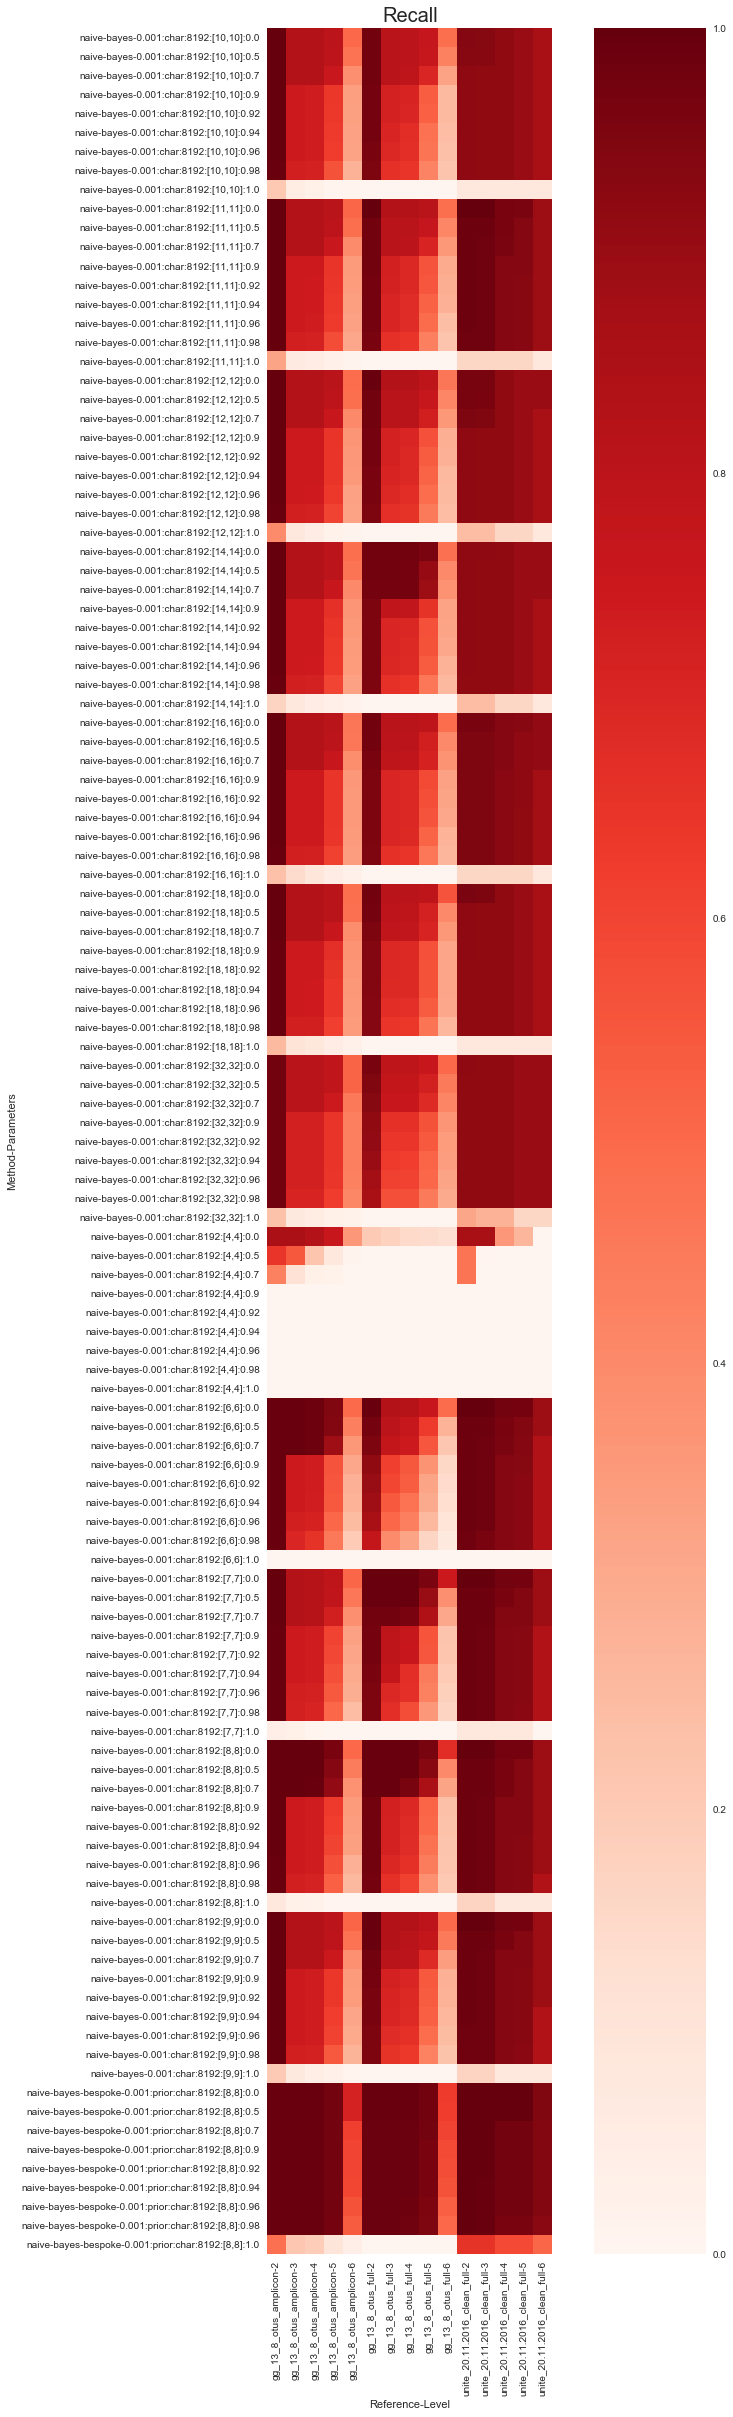

In [12]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

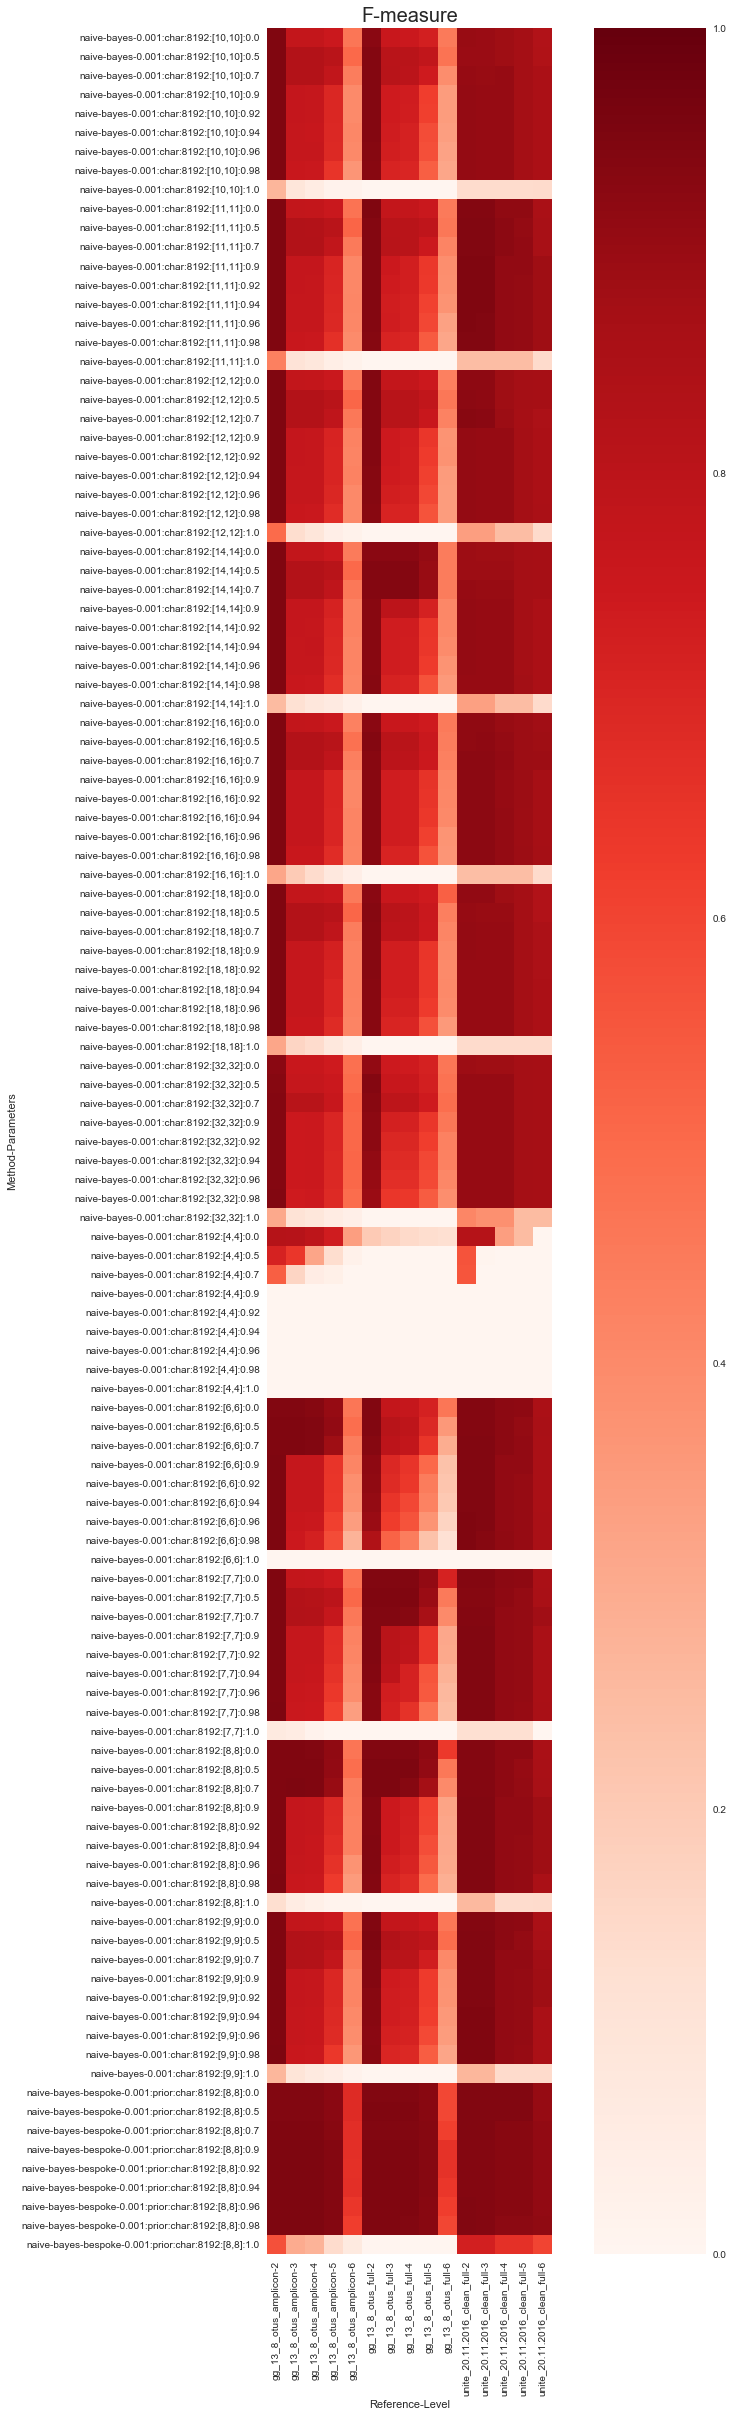

In [13]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

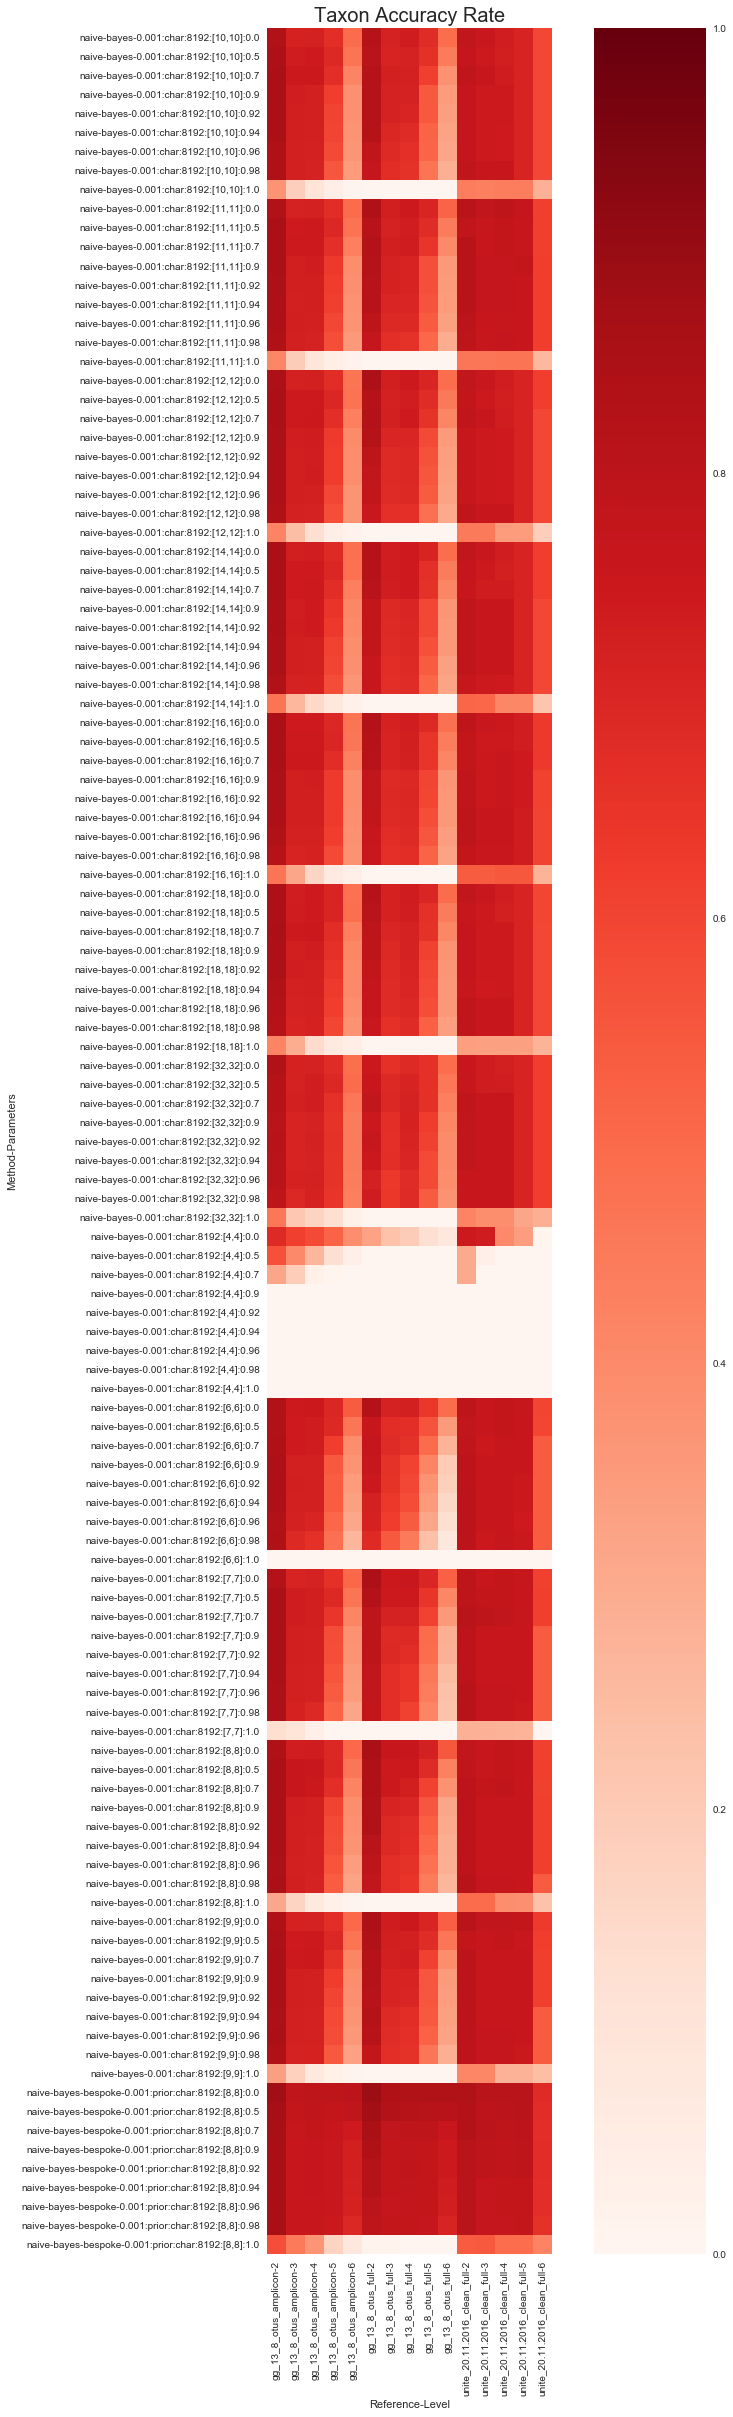

In [14]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

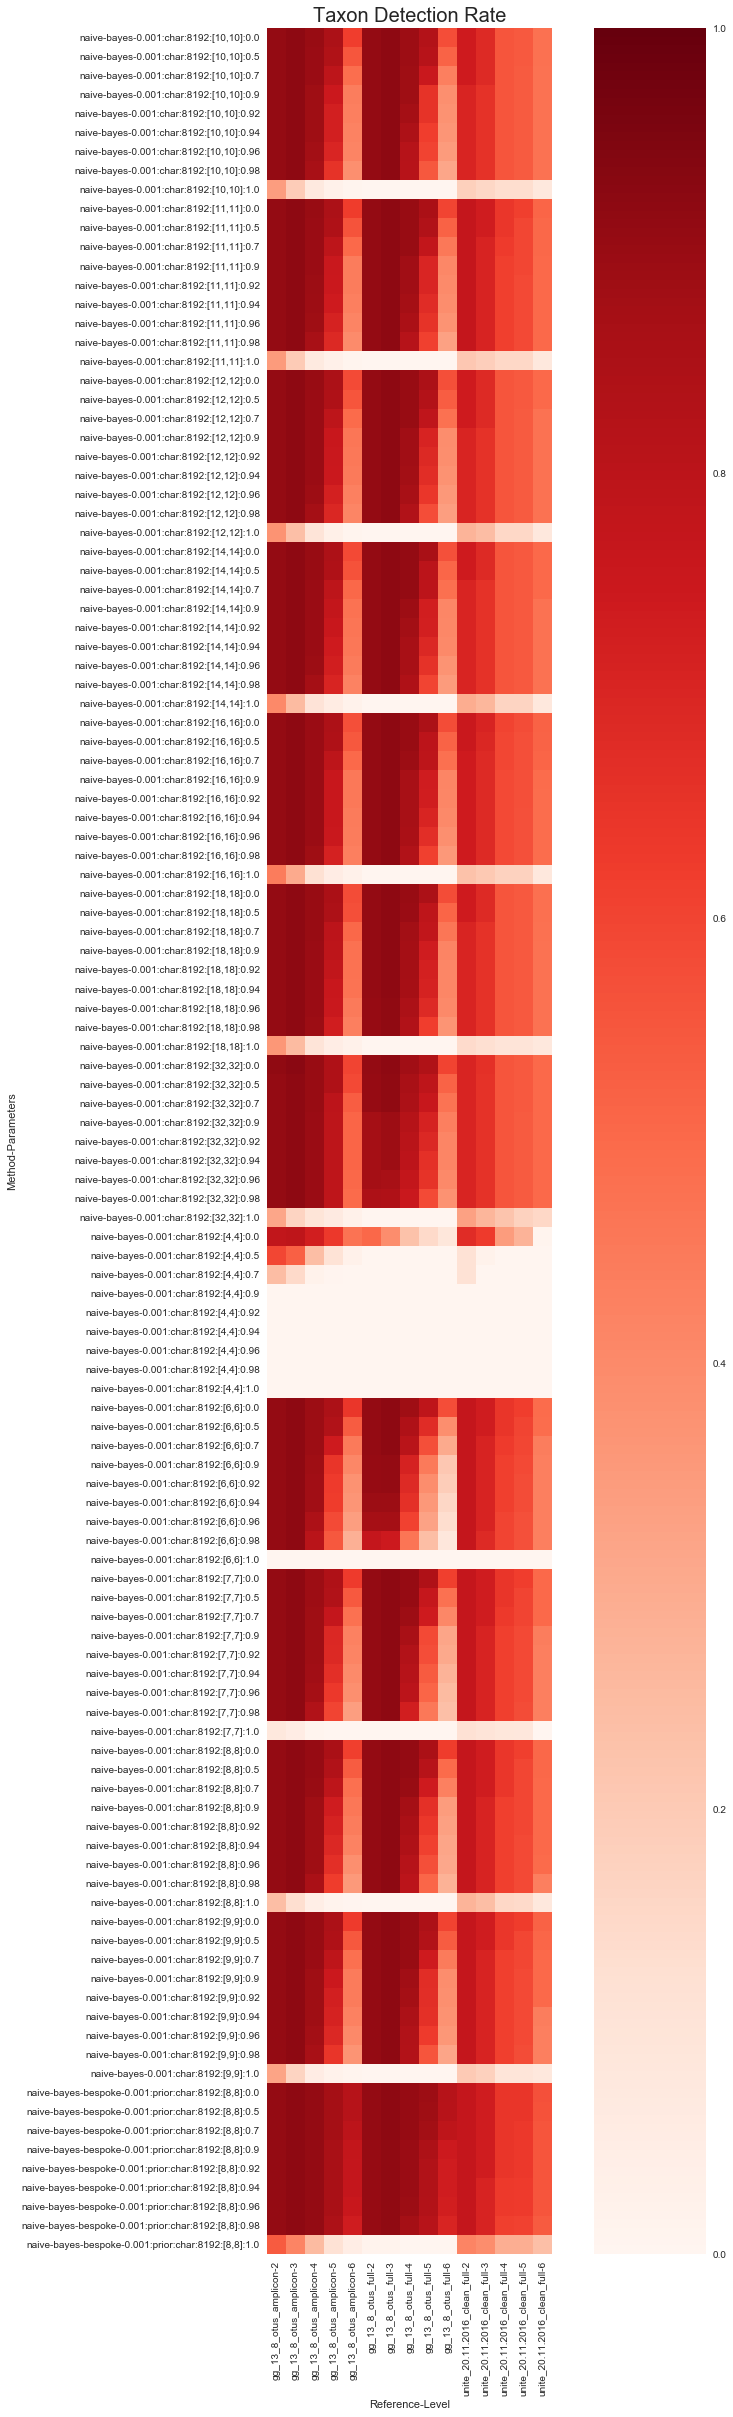

In [15]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at species level (for genus level, change to level 5)

In [16]:
mock_results_6 = mock_results[mock_results['Level'] == 4]

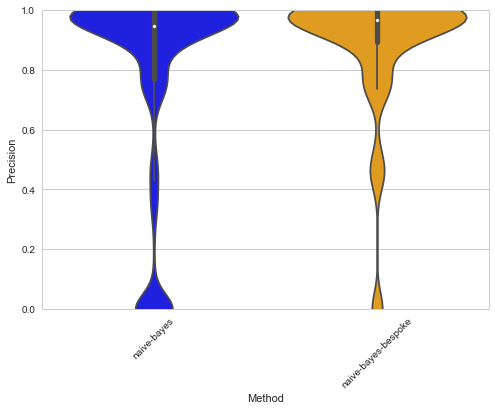

In [17]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

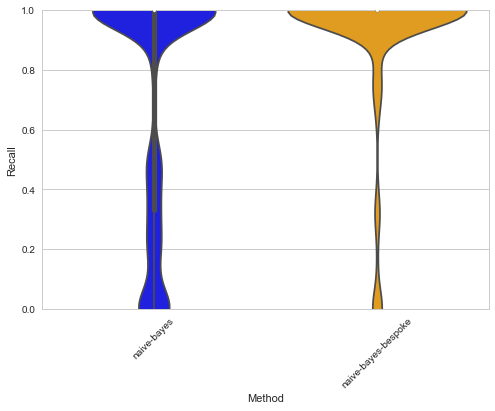

In [18]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

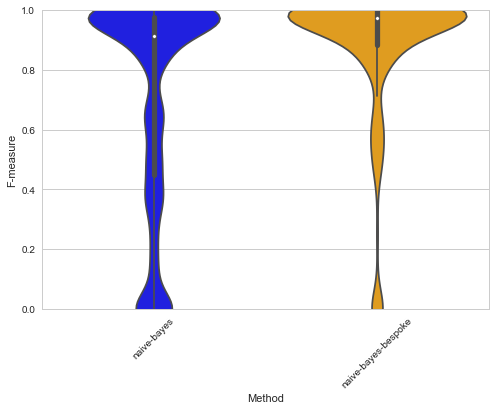

In [19]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

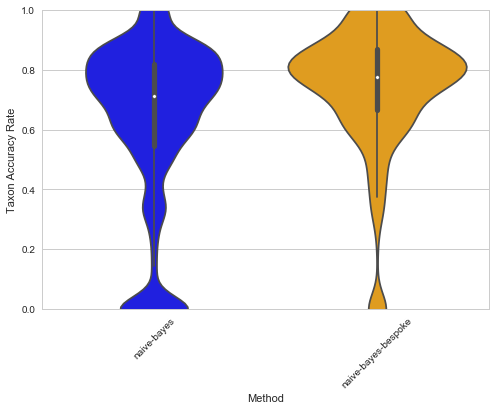

In [20]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Accuracy Rate", color_pallette=color_pallette)

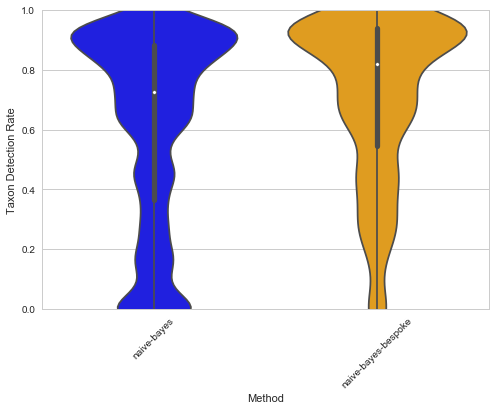

In [21]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Detection Rate", color_pallette=color_pallette)

In the following heatmaps, we assess accuracy rates in each dataset X method configuration combination. This allows us to assess how evenly configurations affect performance, whether specific mock communities outperform of underperform relative to others, and generally assess how increasing/decreasing specific parameters affects accuracy.

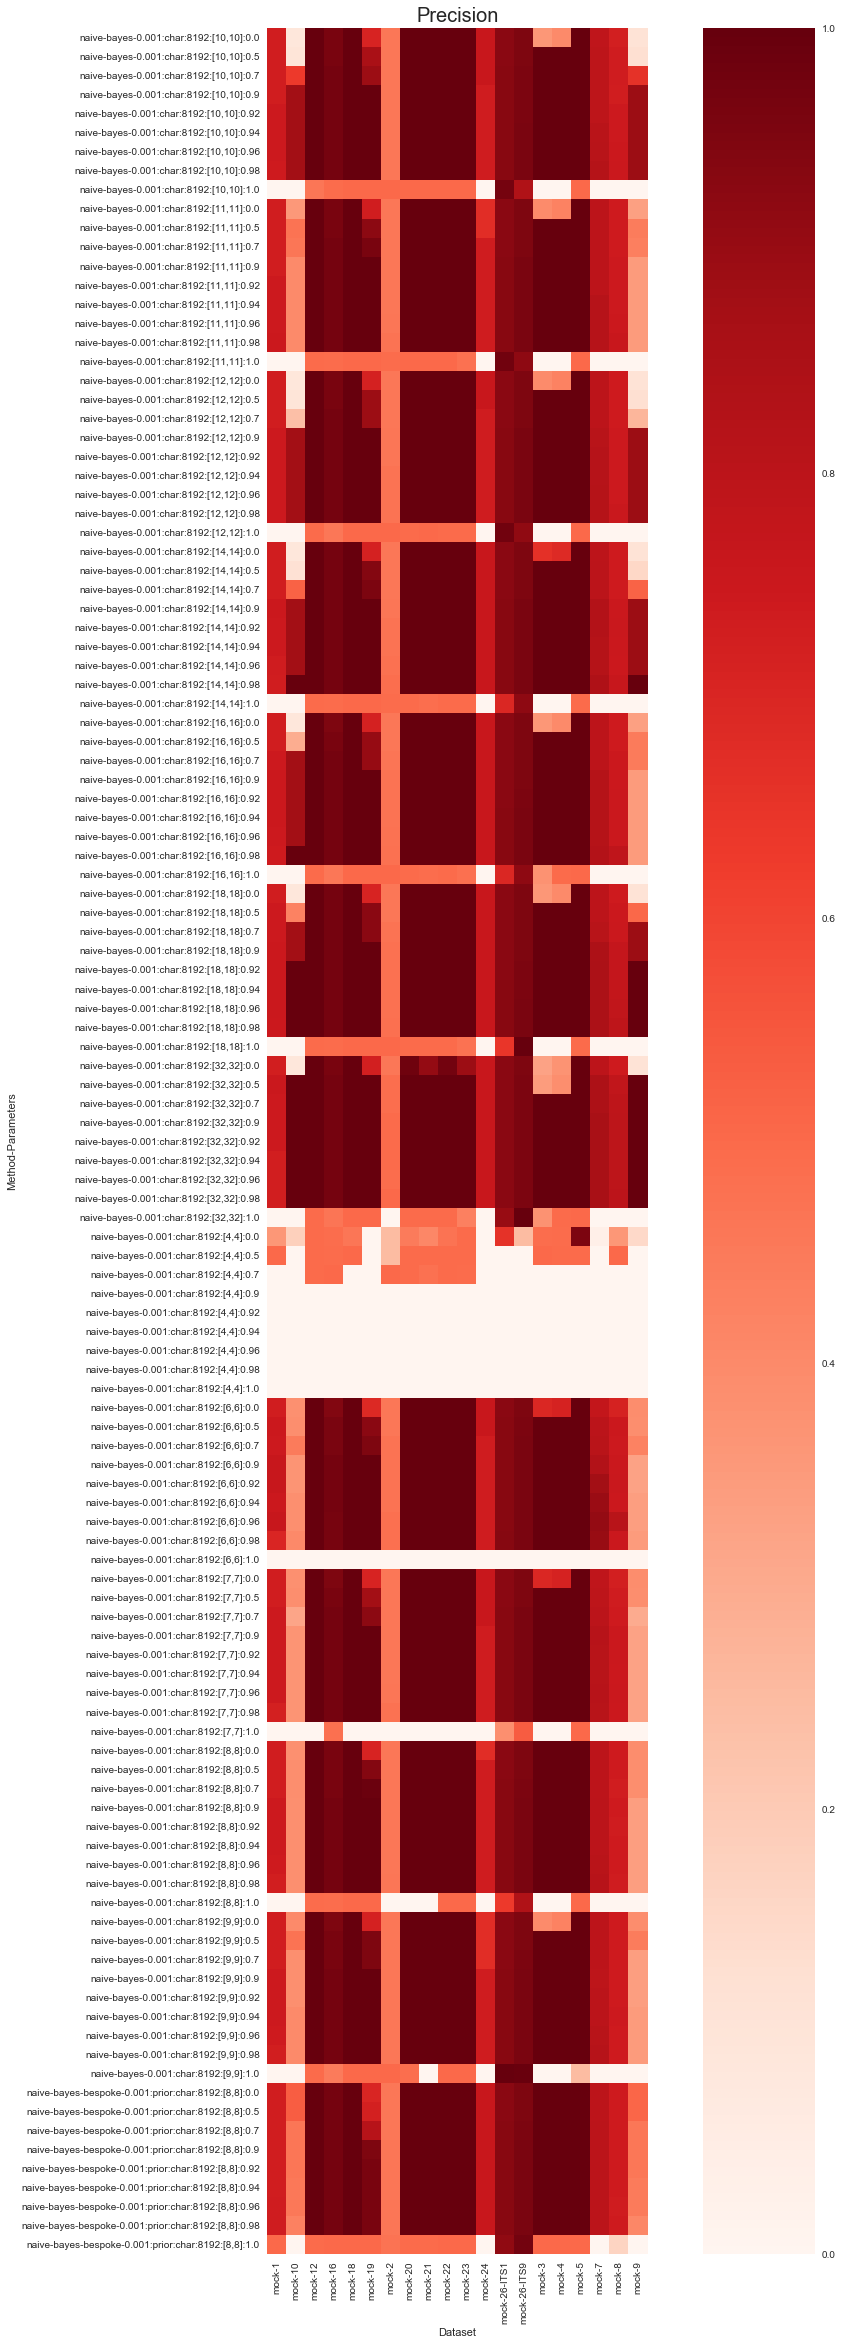

In [22]:
heatmap_from_data_frame(mock_results_6, "Precision")

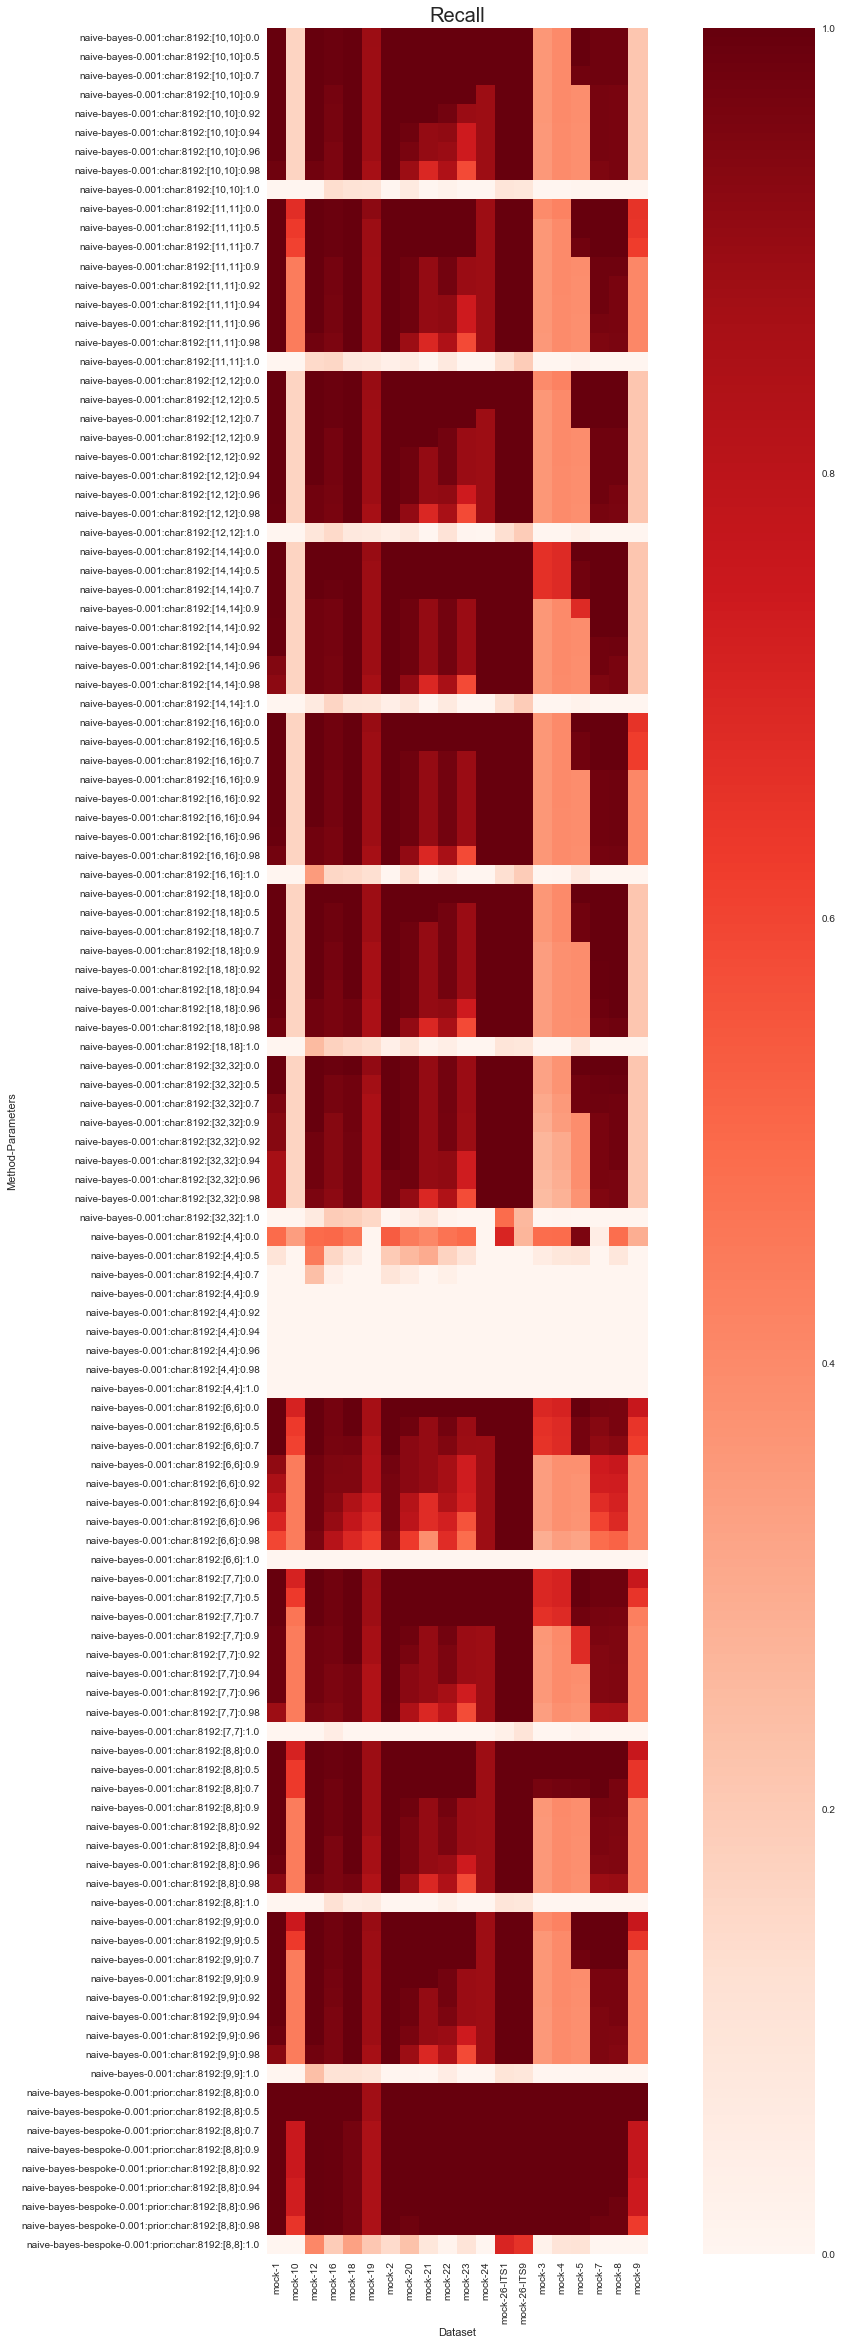

In [23]:
heatmap_from_data_frame(mock_results_6, "Recall")

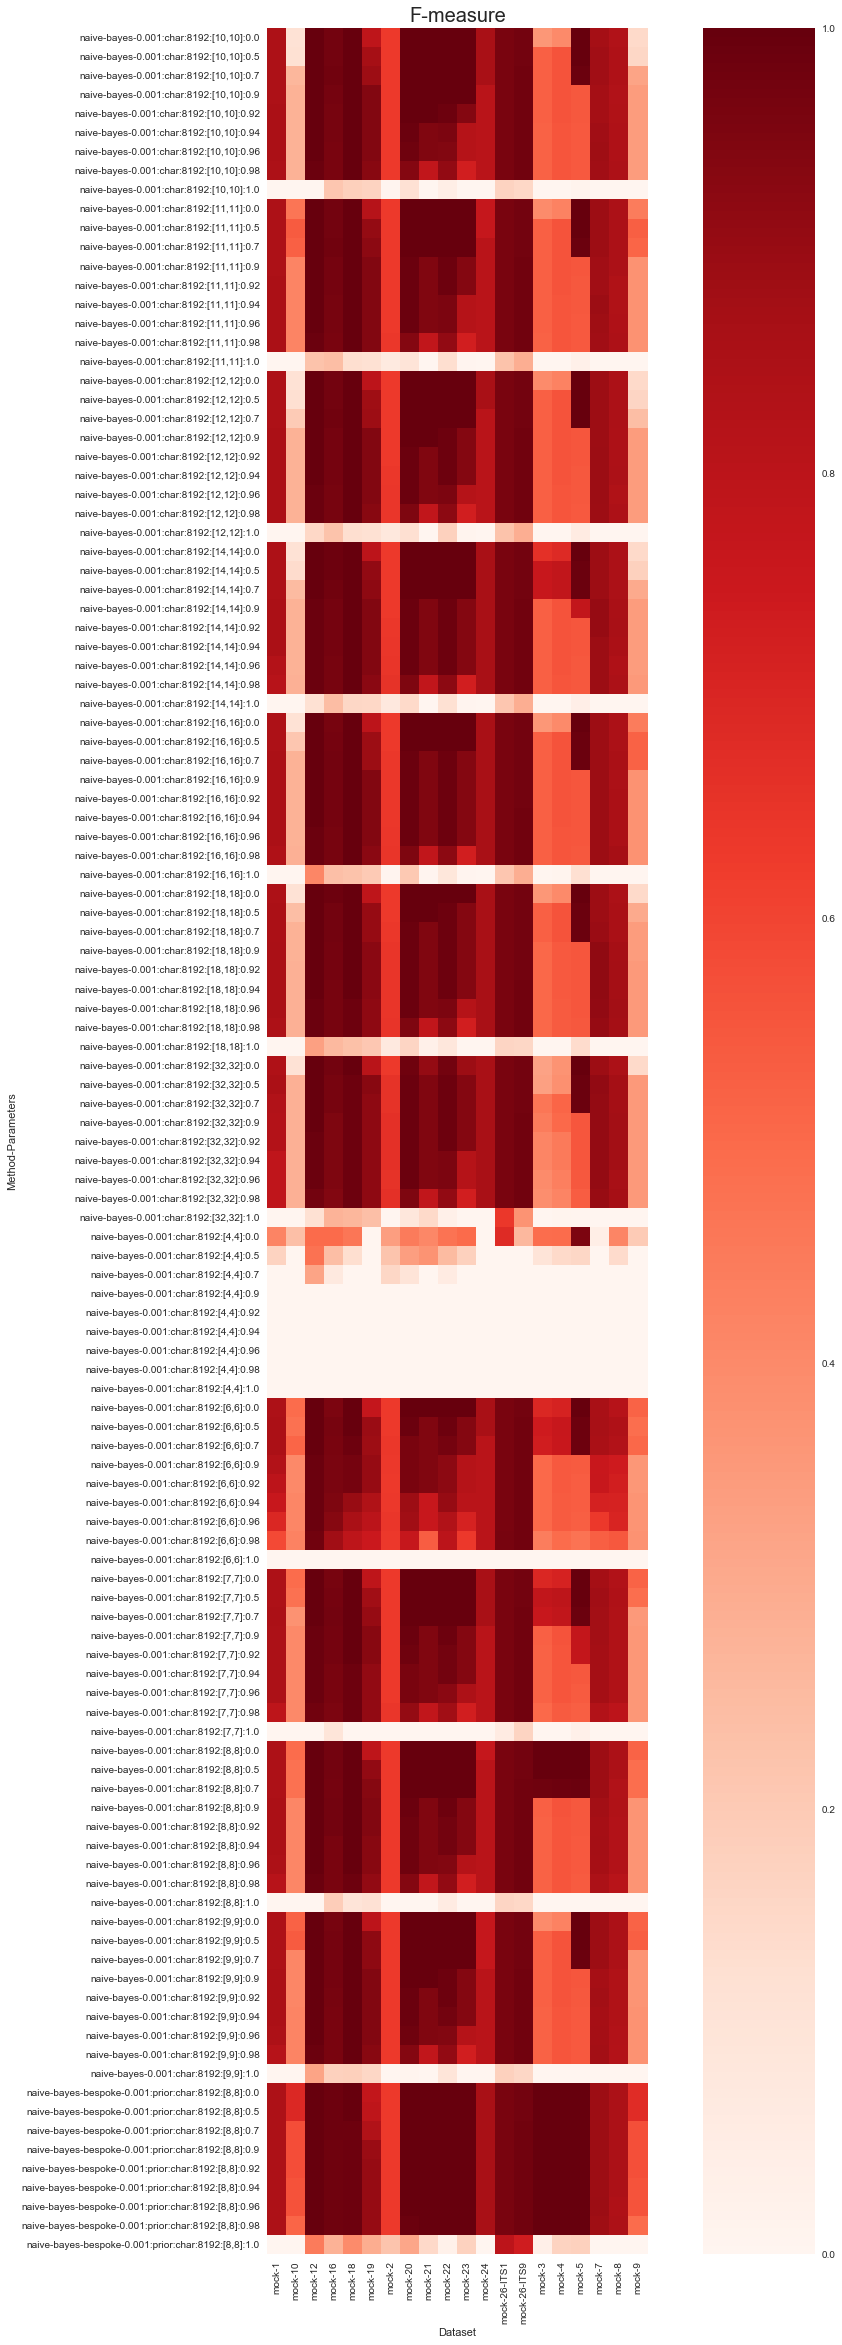

In [24]:
heatmap_from_data_frame(mock_results_6, "F-measure")

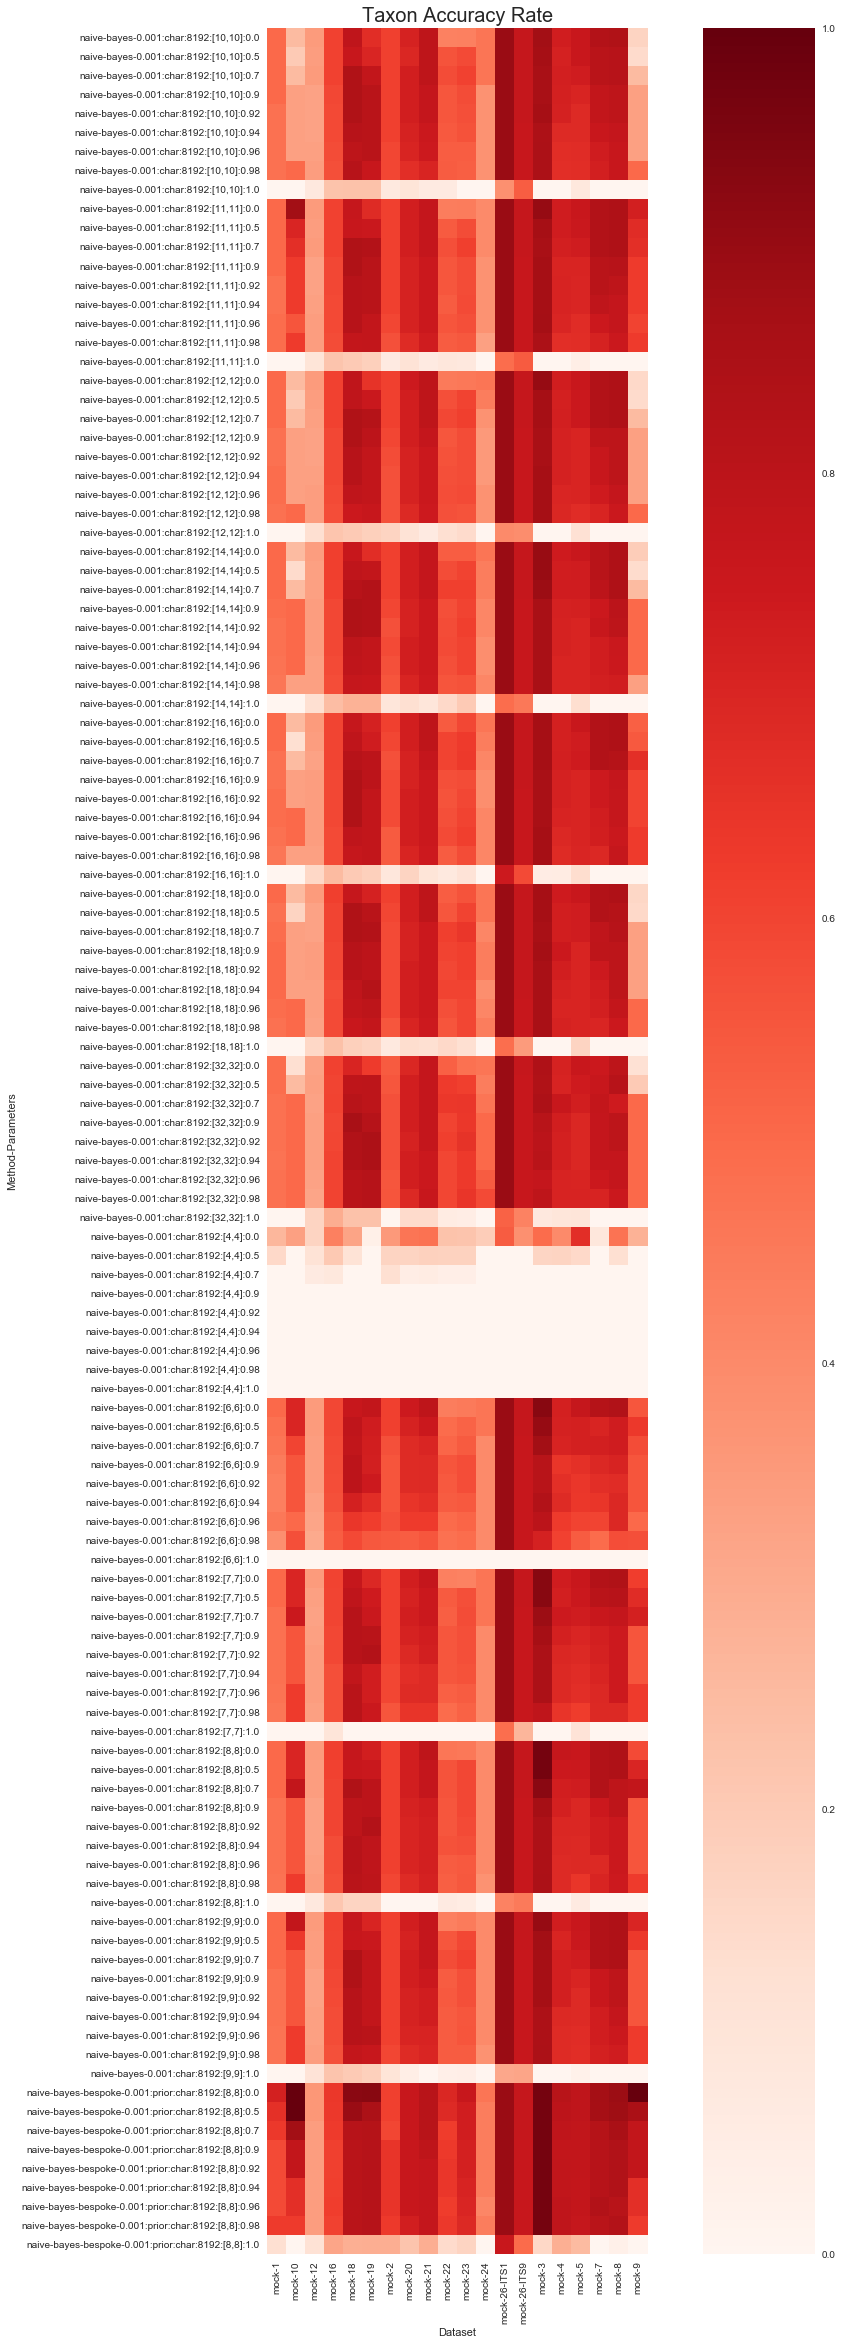

In [25]:
heatmap_from_data_frame(mock_results_6, "Taxon Accuracy Rate")

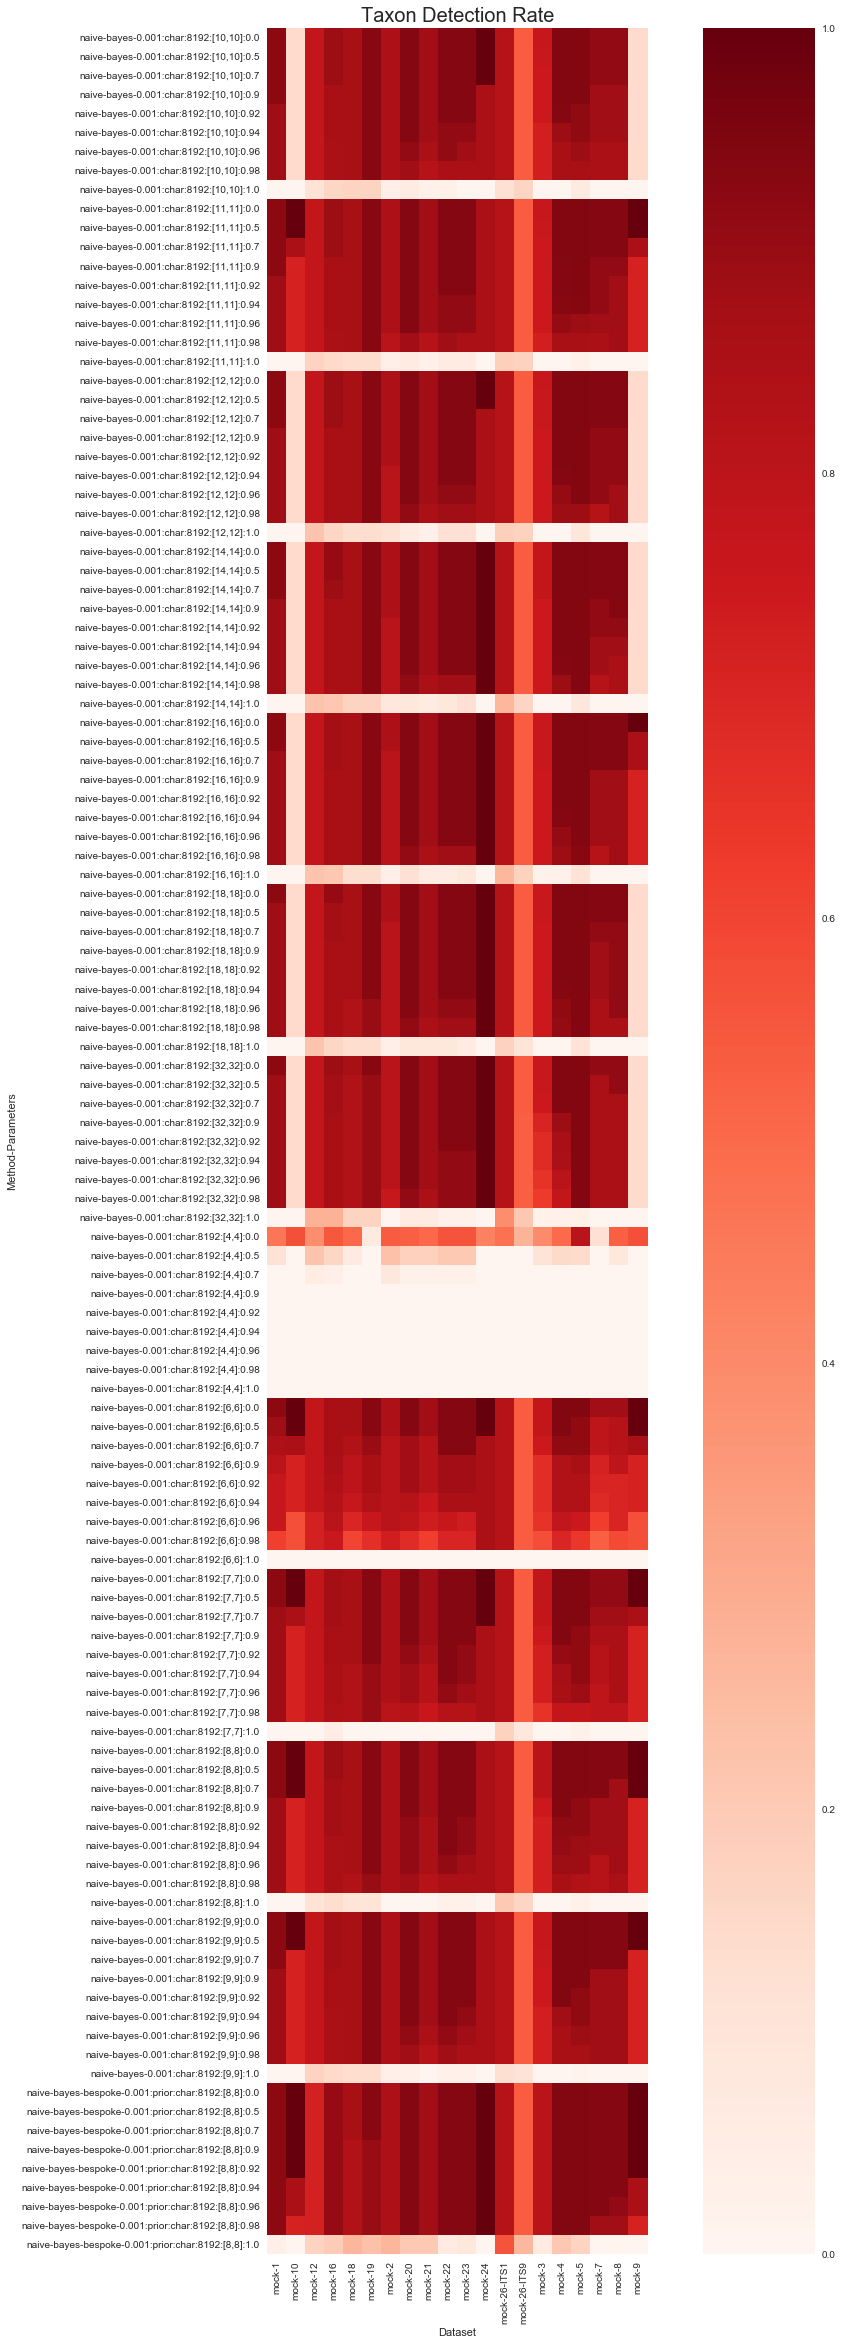

In [26]:
heatmap_from_data_frame(mock_results_6, "Taxon Detection Rate")

In [27]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

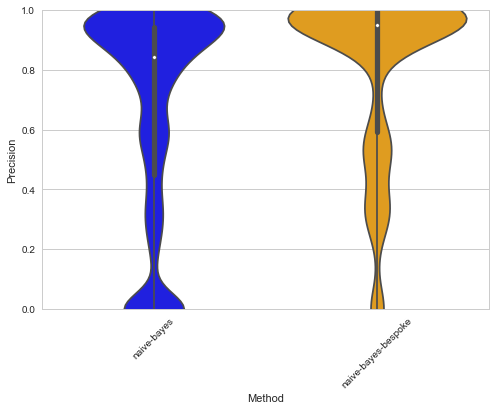

In [28]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

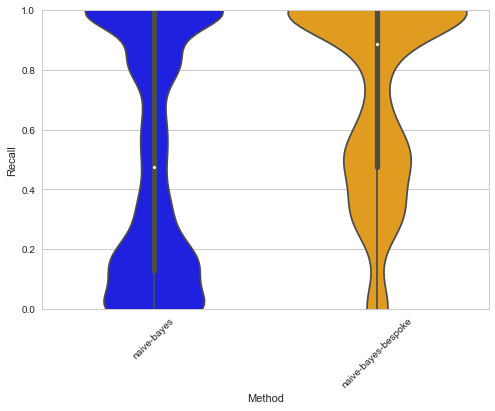

In [29]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

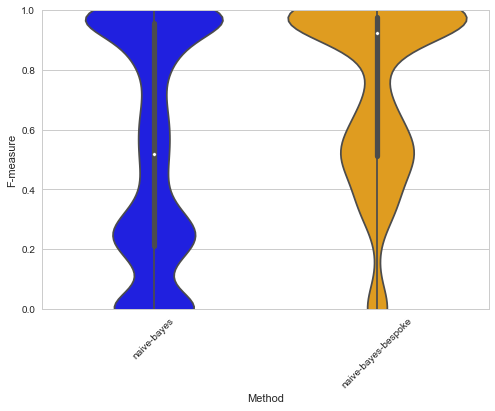

In [30]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

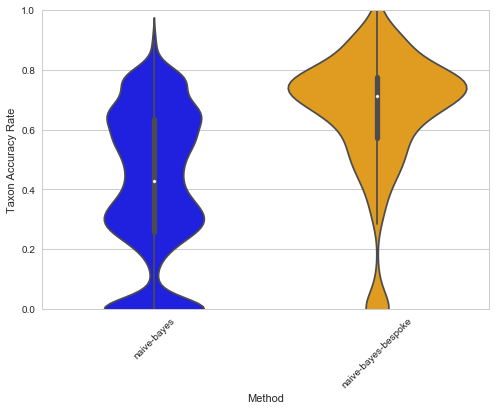

In [31]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Accuracy Rate", color_pallette=color_pallette)

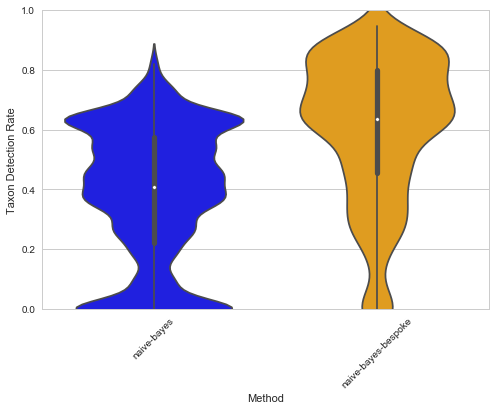

In [32]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Detection Rate", color_pallette=color_pallette)

In the following heatmaps, we assess accuracy rates in each dataset X method configuration combination. This allows us to assess how evenly configurations affect performance, whether specific mock communities outperform of underperform relative to others, and generally assess how increasing/decreasing specific parameters affects accuracy.

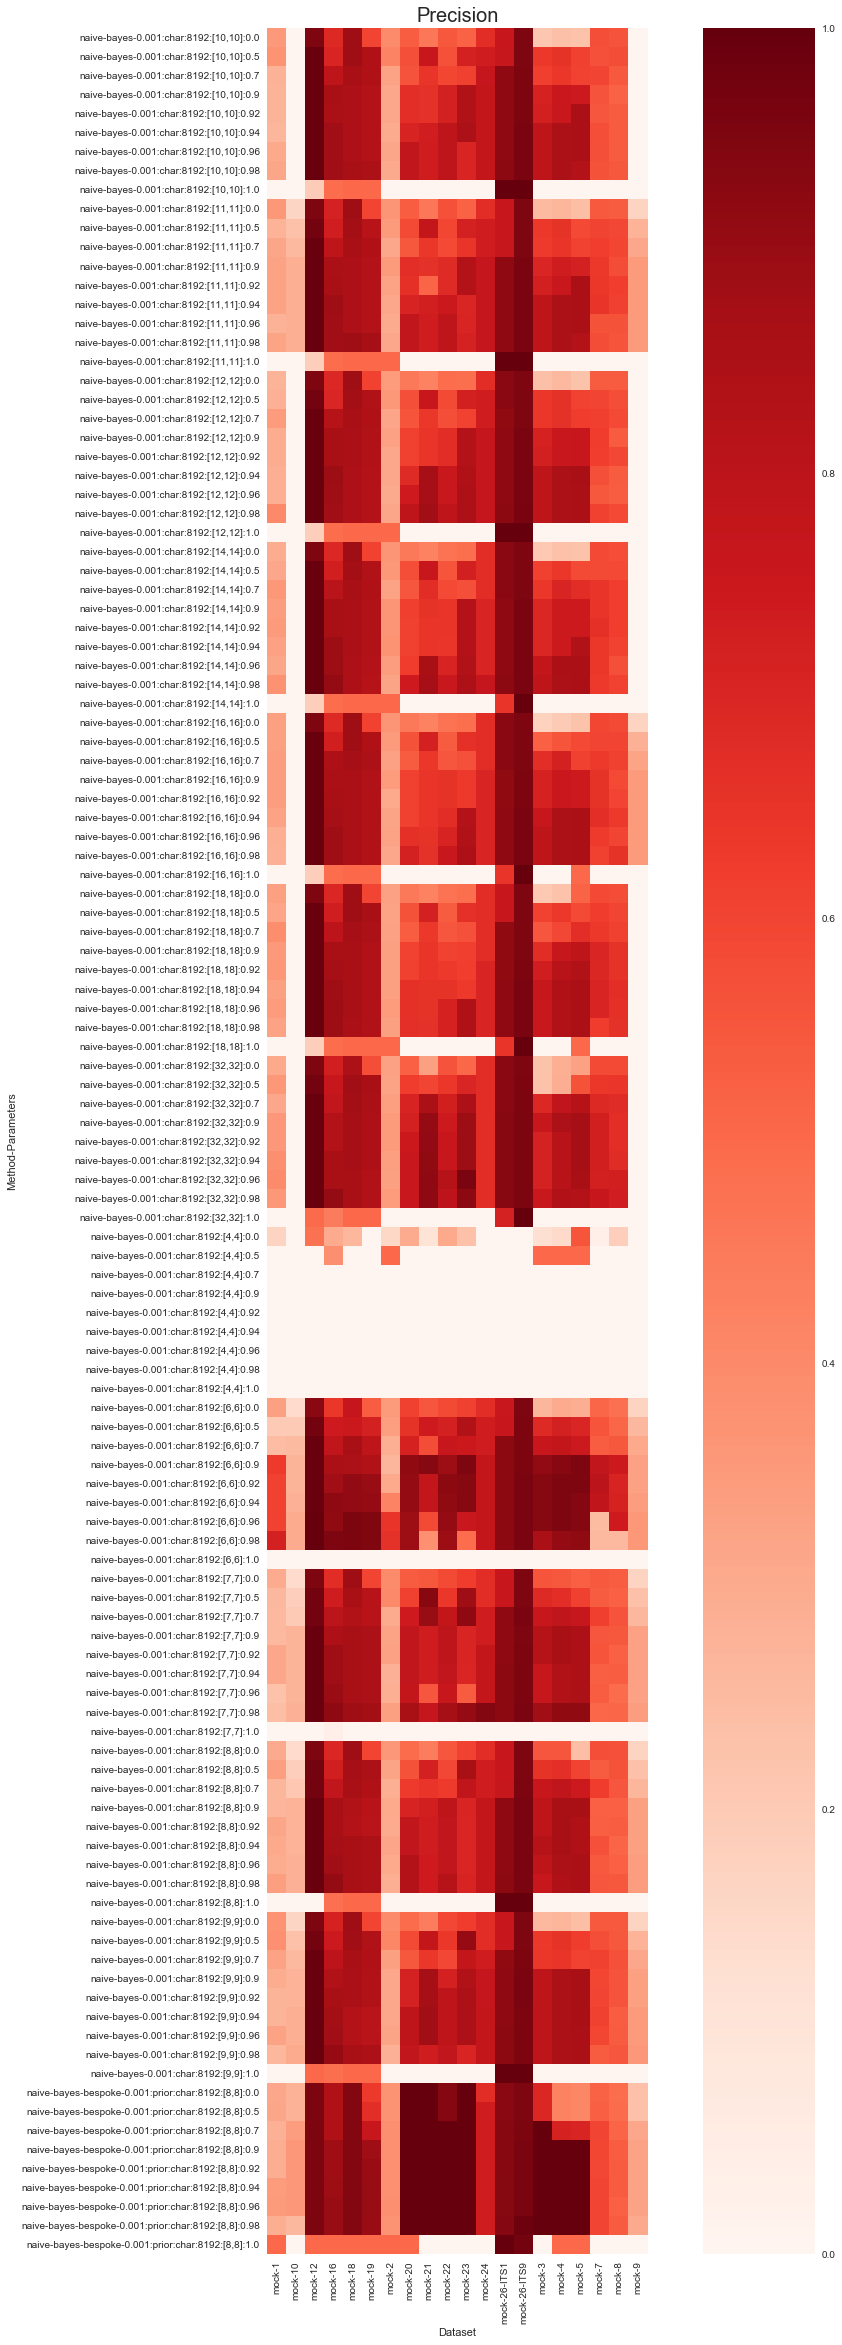

In [33]:
heatmap_from_data_frame(mock_results_6, "Precision")

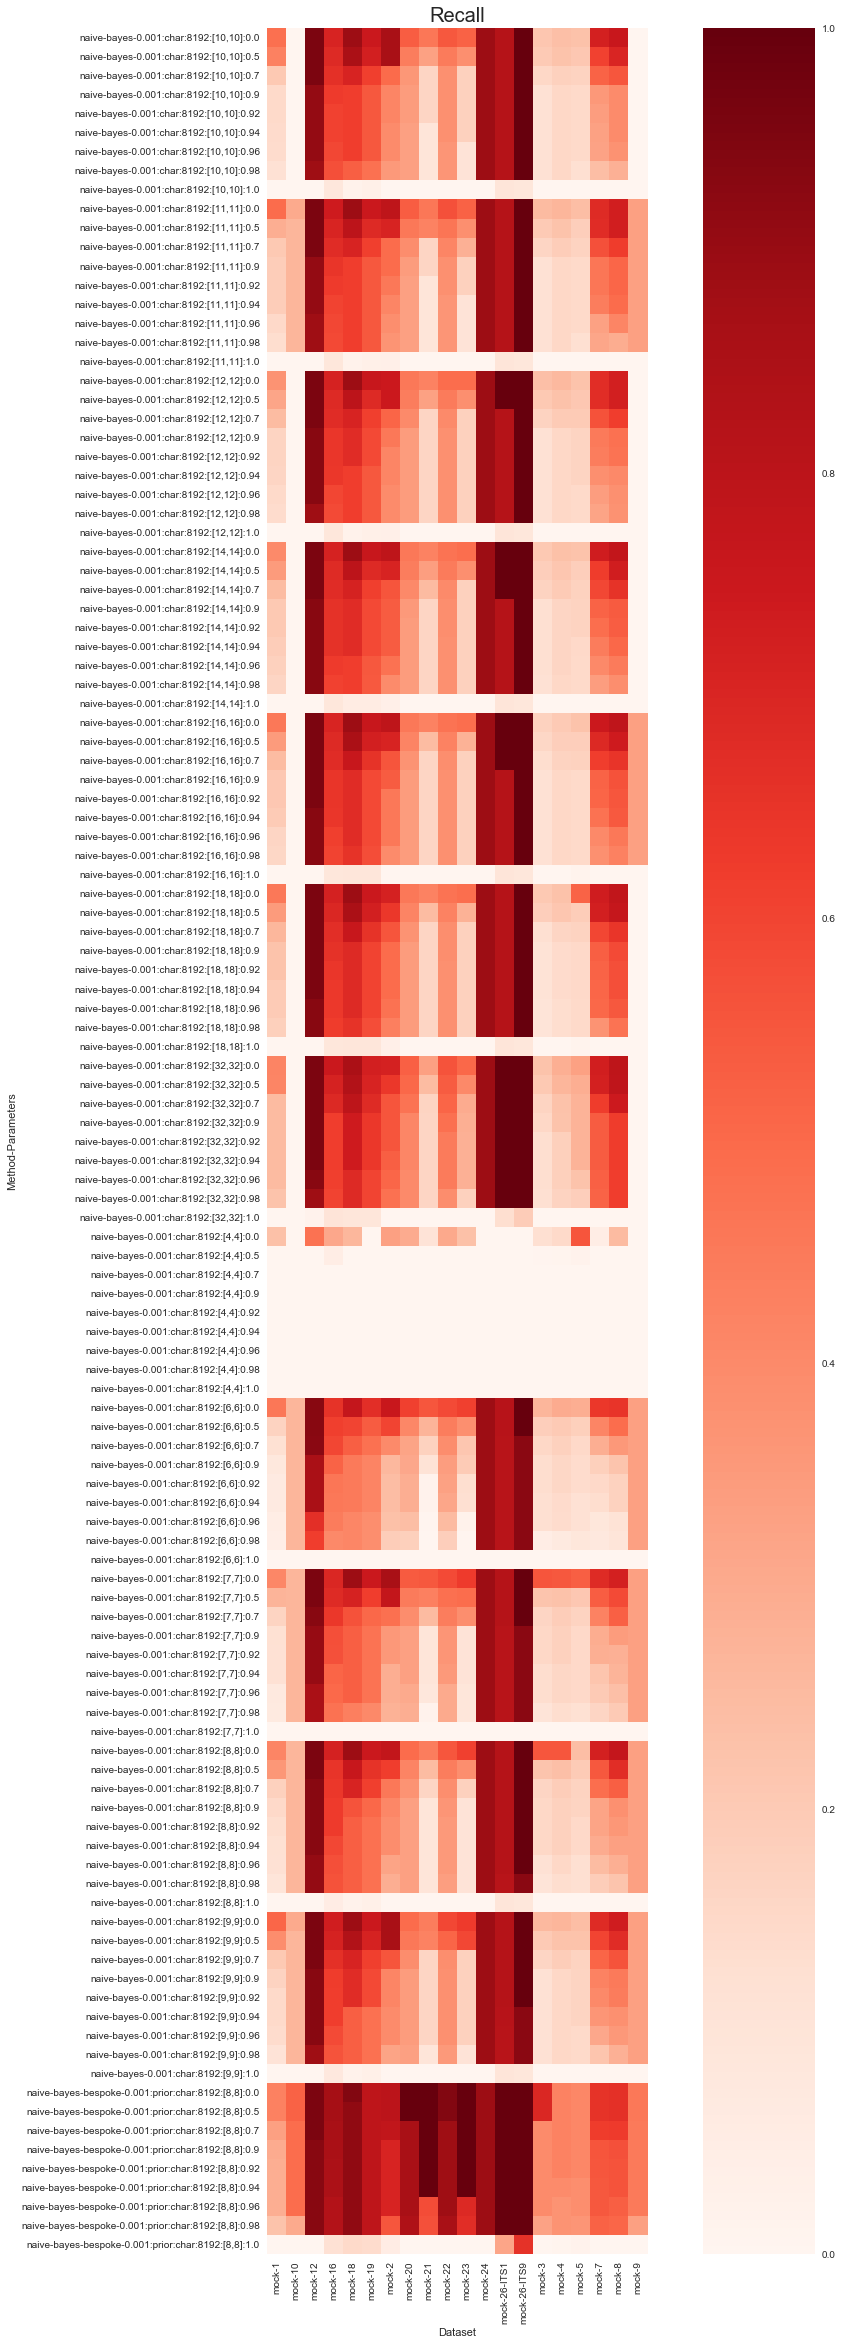

In [34]:
heatmap_from_data_frame(mock_results_6, "Recall")

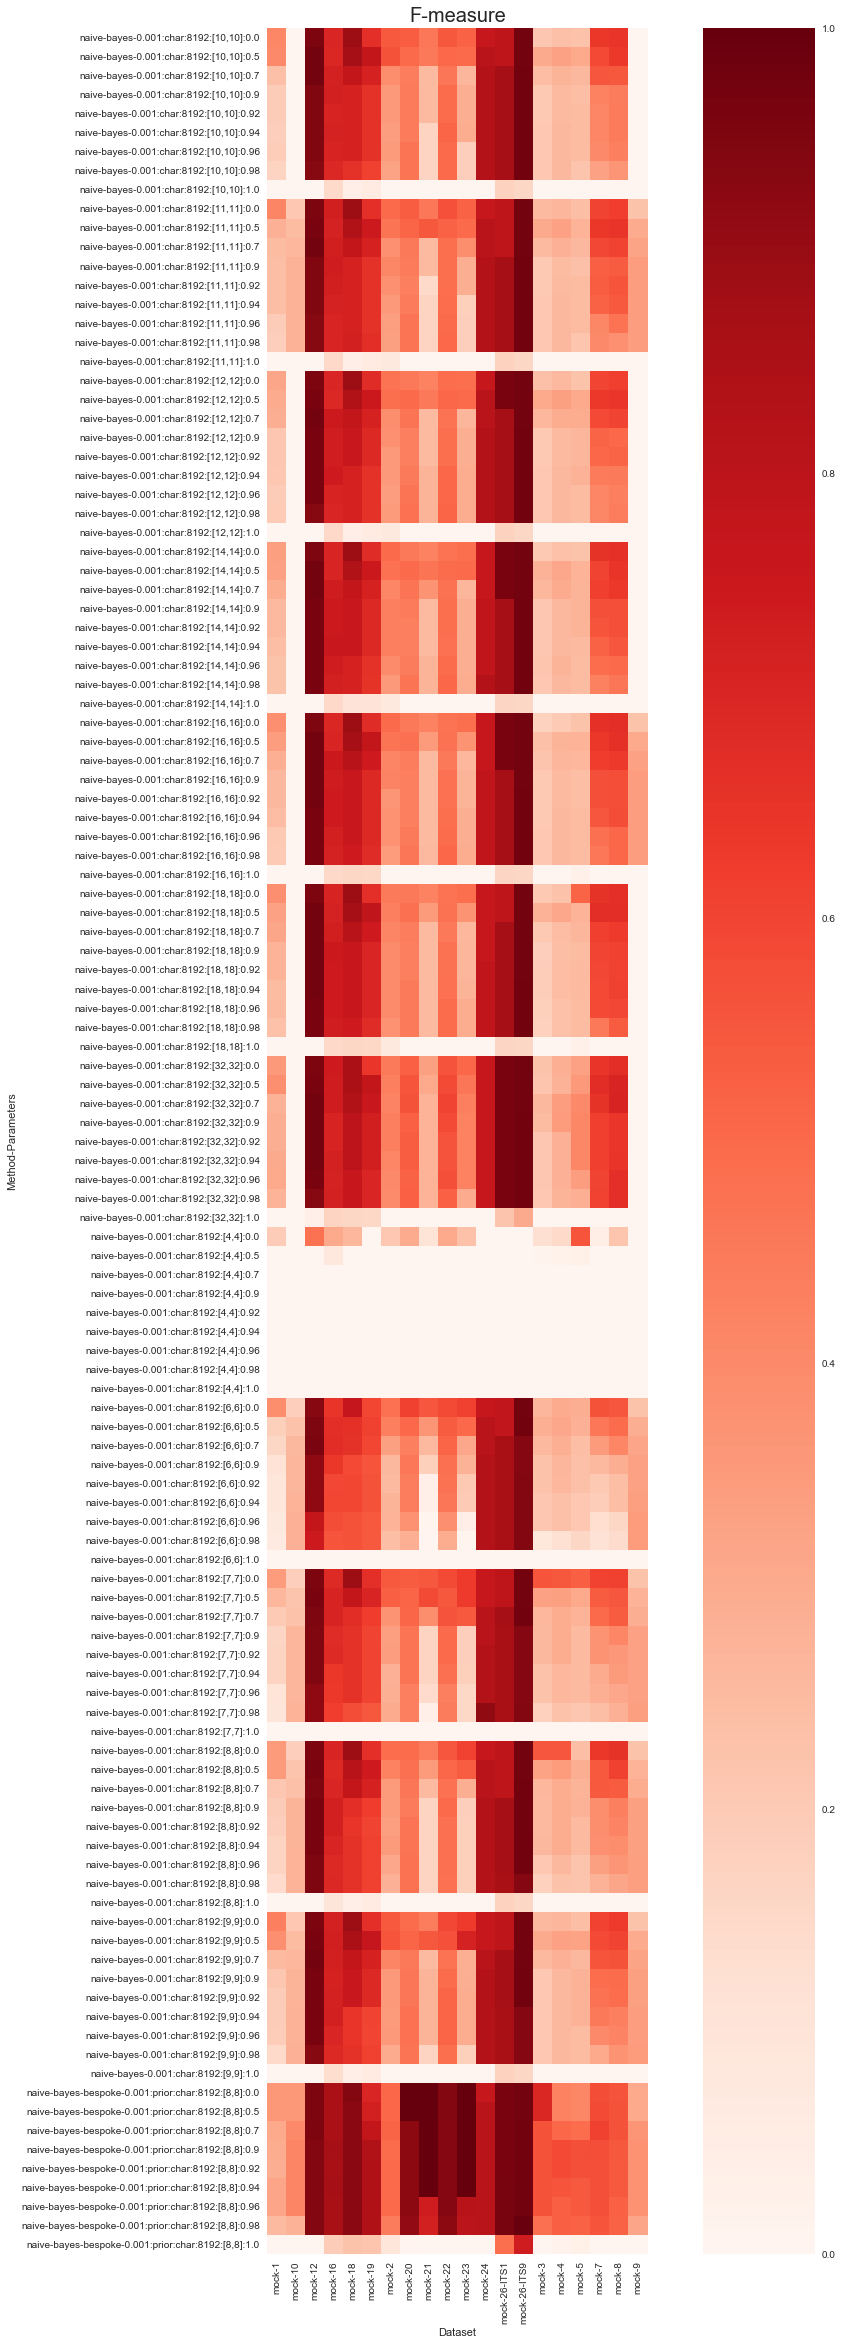

In [35]:
heatmap_from_data_frame(mock_results_6, "F-measure")

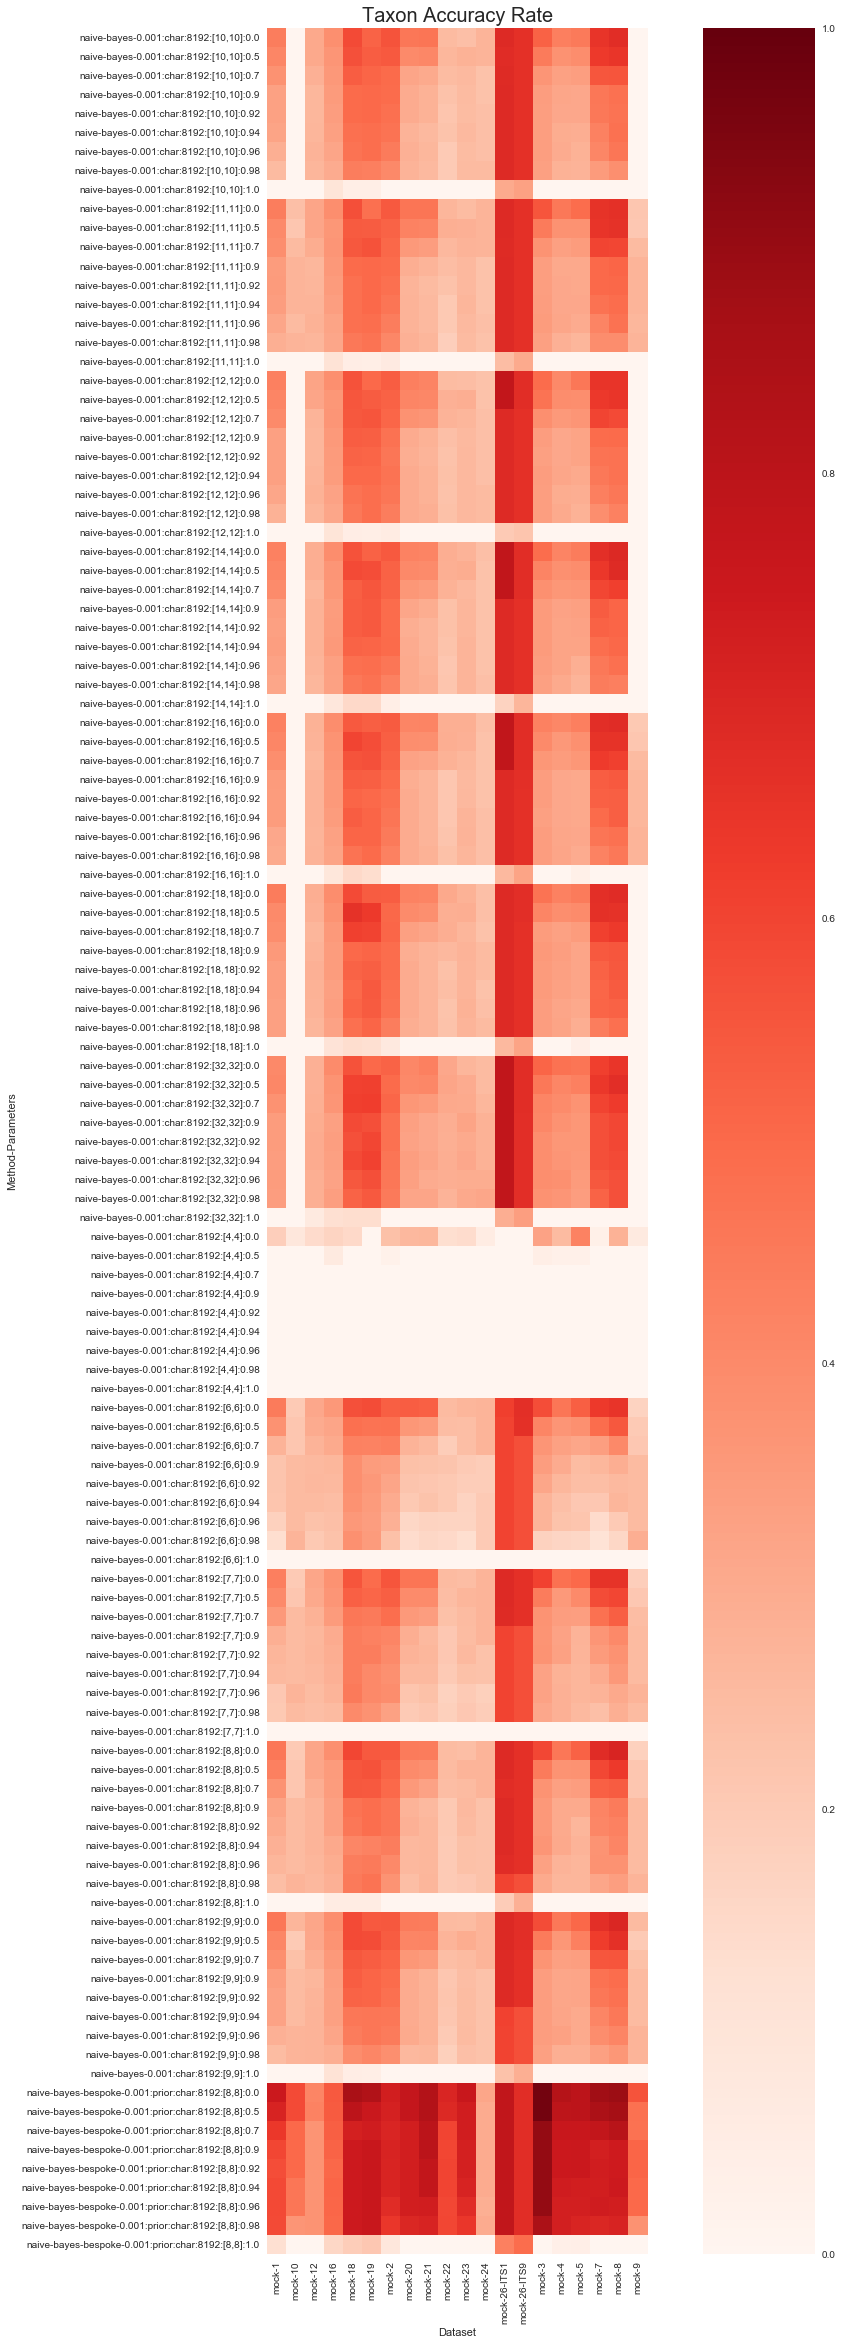

In [36]:
heatmap_from_data_frame(mock_results_6, "Taxon Accuracy Rate")

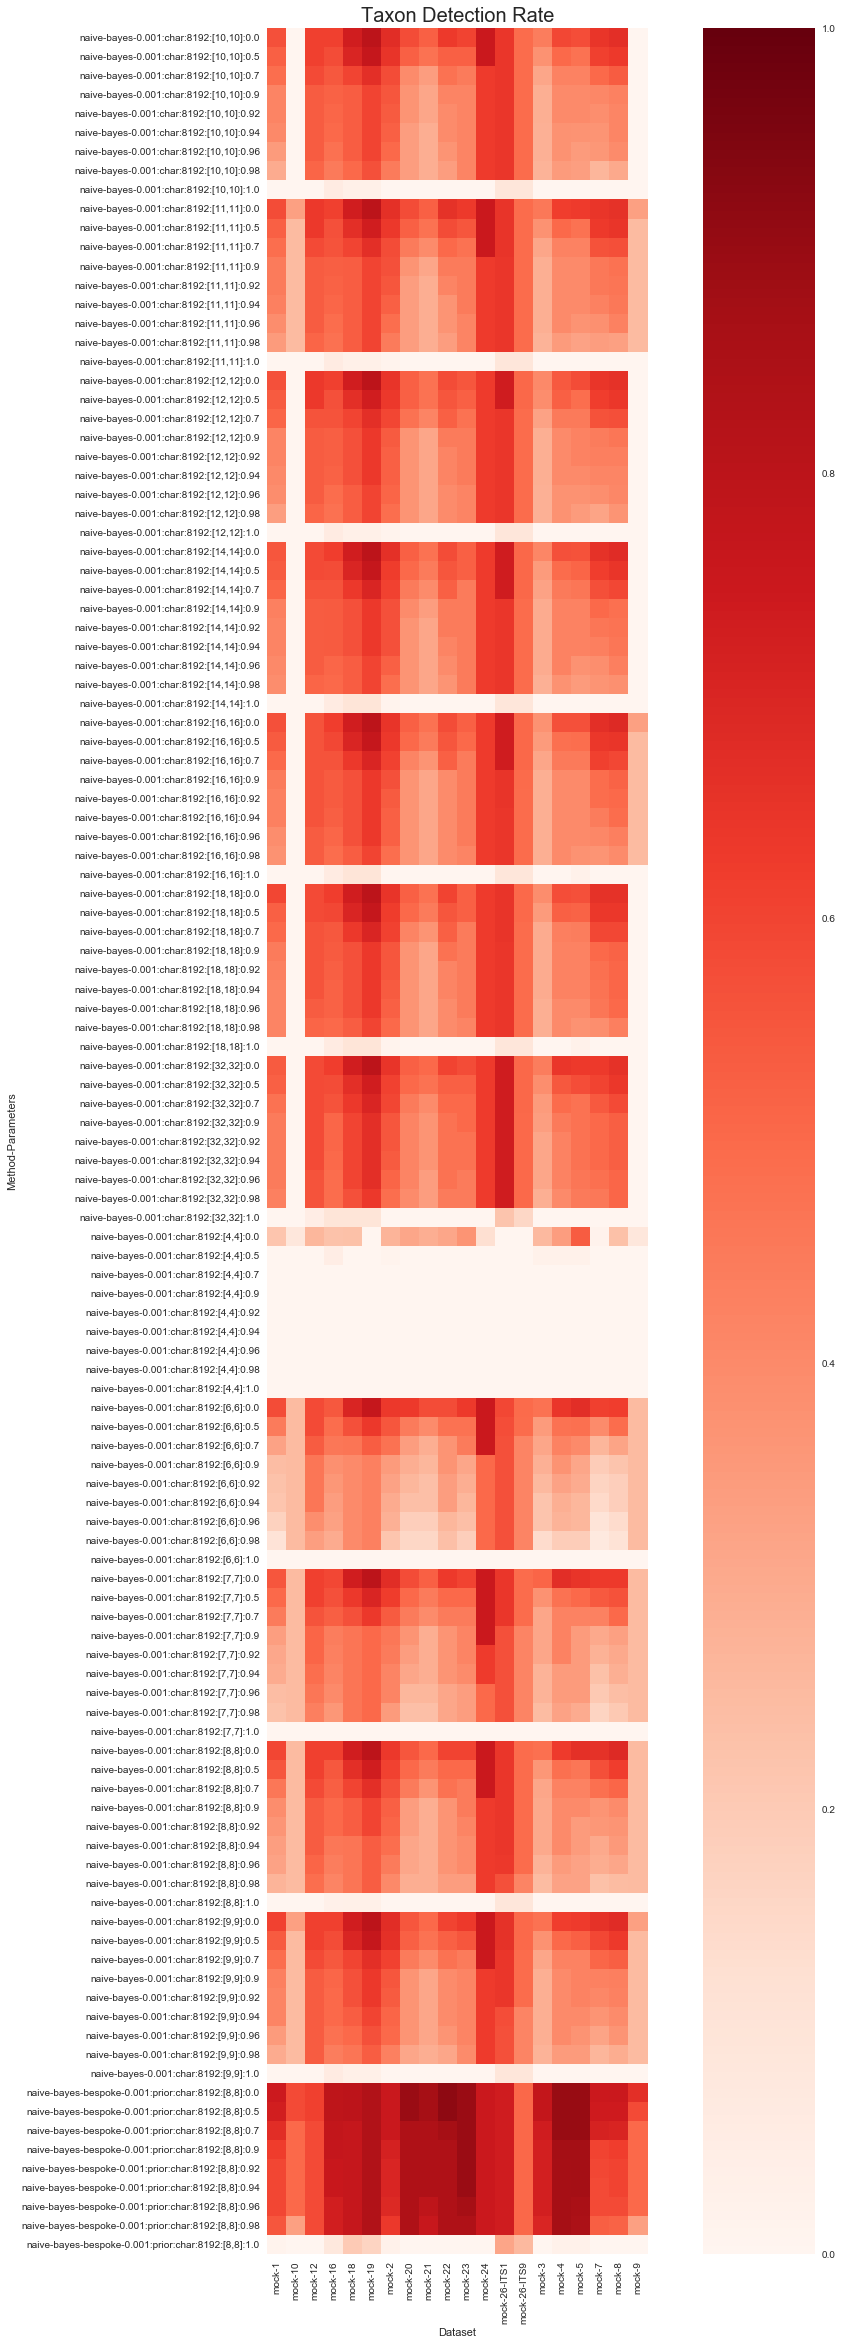

In [37]:
heatmap_from_data_frame(mock_results_6, "Taxon Detection Rate")

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [38]:
for i in [n for n in range(1,27)]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

Method                       Parameters  Precision  \
49           naive-bayes      0.001:char:8192:[11,11]:0.0   0.482095   
549  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.5   0.364243   

       Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
49   0.659208   0.556909             0.469388              0.621622  
549  0.498040   0.420761             0.651163              0.756757

## mock-2

Method                        Parameters  Precision  \
9954          naive-bayes       0.001:char:8192:[10,10]:0.5   0.421930   
9929  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.94   0.402271   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
9954  0.862307   0.566614             0.545455              0.648649  
9929  0.783508   0.531604             0.692308              0.729730

## mock-3

Method                       Parameters  Precision  \
79398  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0    1.00000   
81378          naive-bayes        0.001:char:8192:[8,8]:0.0    0.94379   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
79398  1.00000    1.00000             1.000000                  0.65  
81378  0.94379    0.94379             0.615385                  0.40

## mock-4

Method                       Parameters  Precision  \
86058          naive-bayes        0.001:char:8192:[8,8]:0.0   0.951479   
86476  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.9   0.999931   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
86058  0.951748   0.951613             0.448276                  0.65  
86476  0.522723   0.686547             0.772727                  0.85

## mock-5

Method                        Parameters  Precision  \
90558          naive-bayes         0.001:char:8192:[7,7]:0.0   0.950325   
88876  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.96   0.999987   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
90558  0.950406   0.950366             0.448276                  0.65  
88876  0.516356   0.681045             0.739130                  0.85

## mock-6

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-7

Method                       Parameters  Precision  \
93867          naive-bayes      0.001:char:8192:[32,32]:0.7   0.777695   
92924  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.7   0.622252   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
93867  0.676874   0.723790                  0.6              0.500000  
92924  0.656767   0.639044                  0.8              0.740741

## mock-8

Method                       Parameters  Precision  \
97364          naive-bayes      0.001:char:8192:[32,32]:0.5   0.700096   
96434  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.7   0.569518   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
97364  0.779027   0.737456             0.666667              0.629630  
96434  0.665094   0.613606             0.784314              0.740741

## mock-9

Method                        Parameters  Precision  \
101727  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.92   0.329542   
101233          naive-bayes        0.001:char:8192:[6,6]:0.98   0.357832   

          Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
101727  0.457203   0.383015             0.500000                  0.50  
101233  0.345213   0.351409             0.272727                  0.25

## mock-10

Method                        Parameters  Precision  \
4633  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.94   0.383666   
4123          naive-bayes        0.001:char:8192:[6,6]:0.98   0.322401   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
4633  0.522668   0.442508             0.461538                  0.50  
4123  0.289107   0.304848             0.272727                  0.25

## mock-11

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-12

Method                       Parameters  Precision  \
5319          naive-bayes      0.001:char:8192:[11,11]:0.5   0.995067   
5819  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.7   0.956604   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
5319  0.954609   0.974419             0.302326                  0.65  
5819  0.956875   0.956740             0.413793                  0.60

## mock-13

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-14

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-15

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-16

Method                       Parameters  Precision  \
6994  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.9   0.919457   
6014          naive-bayes     0.001:char:8192:[14,14]:0.94   0.886406   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
6994  0.869038   0.893537             0.534247                  0.78  
6014  0.683612   0.771912             0.376623                  0.58

## mock-17

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-18

Method                       Parameters  Precision  \
8149  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0   0.997895   
7029          naive-bayes      0.001:char:8192:[10,10]:0.5   0.888547   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
8149  1.000000   0.998946             0.928571              0.866667  
7029  0.888565   0.888556             0.578947              0.733333

## mock-19

Method                        Parameters  Precision  \
9349  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.96   0.929600   
8469          naive-bayes       0.001:char:8192:[32,32]:0.5   0.867344   

        Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
9349  0.830550   0.877288             0.812500              0.866667  
8469  0.753607   0.806485             0.631579              0.800000

## mock-20

Method                       Parameters  Precision  \
11664  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.5   0.999226   
10894          naive-bayes        0.001:char:8192:[6,6]:0.0   0.621106   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
11664  1.000000   0.999613             0.772727              0.894737  
10894  0.621587   0.621347             0.521739              0.631579

## mock-21

Method                       Parameters  Precision  \
12259  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.9   0.999677   
12069          naive-bayes        0.001:char:8192:[6,6]:0.5   0.946442   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
12259  1.000000   0.999839             0.761905              0.842105  
12069  0.514867   0.666925             0.428571              0.473684

## mock-22

Method                       Parameters  Precision  \
13999  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0   0.998680   
13154          naive-bayes      0.001:char:8192:[32,32]:0.7   0.792768   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
13999  1.000000   0.999340             0.750000              0.947368  
13154  0.583059   0.671931             0.322581              0.526316

## mock-23

Method                        Parameters  Precision  \
14609  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.94   0.998784   
14409          naive-bayes         0.001:char:8192:[6,6]:0.5   0.908576   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
14609  0.999846   0.999315             0.607143              0.894737  
14409  0.593286   0.717836             0.270270              0.526316

## mock-24

Method                        Parameters  Precision  \
16239          naive-bayes        0.001:char:8192:[7,7]:0.98   0.941570   
16374  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.98   0.737679   

         Recall  F-measure  Taxon Accuracy Rate  Taxon Detection Rate  
16239  0.889646   0.914872             0.190476                  0.50  
16374  0.889646   0.806567             0.300000                  0.75

## mock-25

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-26

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [39]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Precision', 'Recall', 'F-measure',
                 'Taxon Accuracy Rate', 'Taxon Detection Rate'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:20])

## naive-bayes

F-measure  Precision  Recall  \
0.001:char:8192:[7,7]:0.0         99.0         54    99.0   
0.001:char:8192:[9,9]:0.0         87.0         45    88.0   
0.001:char:8192:[8,8]:0.0         93.0         53    94.0   
0.001:char:8192:[11,11]:0.0       88.0         45    88.0   
0.001:char:8192:[6,6]:0.0         83.0         42    88.0   
0.001:char:8192:[32,32]:0.0       79.0         56    78.0   
0.001:char:8192:[10,10]:0.0       81.0         45    81.0   
0.001:char:8192:[16,16]:0.0       79.0         56    80.0   
0.001:char:8192:[11,11]:0.5       84.0         67    81.0   
0.001:char:8192:[18,18]:0.0       78.0         47    79.0   
0.001:char:8192:[9,9]:0.5         88.0         67    85.0   
0.001:char:8192:[14,14]:0.0       76.0         56    77.0   
0.001:char:8192:[32,32]:0.5       78.0         65    77.0   
0.001:char:8192:[8,8]:0.5         80.0         68    76.0   
0.001:char:8192:[12,12]:0.0       76.0         56    77.0   
0.001:char:8192:[18,18]:0.5       75.0         59    74.0   
0.001:char:8192:[11,11]:0.7       79.0         69    79.0   
0.001:char:8192:[12,12]:0.5       76.0         72    74.0   
0.001:char:8192:[16,16]:0.5       79.0         69    78.0   
0.001:char:8192:[10,10]:0.5       78.0         61    75.0   

                             Taxon Accuracy Rate  Taxon Detection Rate  
0.001:char:8192:[7,7]:0.0                  110.0                 115.0  
0.001:char:8192:[9,9]:0.0                  110.0                 112.0  
0.001:char:8192:[8,8]:0.0                  107.0                 112.0  
0.001:char:8192:[11,11]:0.0                110.0                 109.0  
0.001:char:8192:[6,6]:0.0                  105.0                 106.0  
0.001:char:8192:[32,32]:0.0                 95.0                 100.0  
0.001:char:8192:[10,10]:0.0                 96.0                  95.0  
0.001:char:8192:[16,16]:0.0                 88.0                  91.0  
0.001:char:8192:[11,11]:0.5                 83.0                  90.0  
0.001:char:8192:[18,18]:0.0                 90.0                  90.0  
0.001:char:8192:[9,9]:0.5                   88.0                  89.0  
0.001:char:8192:[14,14]:0.0                 89.0                  88.0  
0.001:char:8192:[32,32]:0.5                 88.0                  86.0  
0.001:char:8192:[8,8]:0.5                   85.0                  86.0  
0.001:char:8192:[12,12]:0.0                 90.0                  85.0  
0.001:char:8192:[18,18]:0.5                 83.0                  84.0  
0.001:char:8192:[11,11]:0.7                 82.0                  83.0  
0.001:char:8192:[12,12]:0.5                 81.0                  83.0  
0.001:char:8192:[16,16]:0.5                 81.0                  83.0  
0.001:char:8192:[10,10]:0.5                 77.0                  81.0

## naive-bayes-bespoke

F-measure  Precision  Recall  \
0.001:prior:char:8192:[8,8]:0.0          71         27     110   
0.001:prior:char:8192:[8,8]:0.5          72         27     110   
0.001:prior:char:8192:[8,8]:0.7          79         50     105   
0.001:prior:char:8192:[8,8]:0.9          93         64      98   
0.001:prior:char:8192:[8,8]:0.92         93         64      98   
0.001:prior:char:8192:[8,8]:0.94         91         64      94   
0.001:prior:char:8192:[8,8]:0.96         85         64      88   
0.001:prior:char:8192:[8,8]:0.98         92         94      76   
0.001:prior:char:8192:[8,8]:1.0           7         53       5   

                                  Taxon Accuracy Rate  Taxon Detection Rate  
0.001:prior:char:8192:[8,8]:0.0                   109                   114  
0.001:prior:char:8192:[8,8]:0.5                   107                   114  
0.001:prior:char:8192:[8,8]:0.7                   102                   111  
0.001:prior:char:8192:[8,8]:0.9                    95                   104  
0.001:prior:char:8192:[8,8]:0.92                   96                   103  
0.001:prior:char:8192:[8,8]:0.94                   91                   103  
0.001:prior:char:8192:[8,8]:0.96                   91                   103  
0.001:prior:char:8192:[8,8]:0.98                   83                    93  
0.001:prior:char:8192:[8,8]:1.0                     8                     5

## Optimized method performance
And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## gg_13_8_otus_amplicon level 4

Method                        Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.96             0.769181   
0          naive-bayes         0.001:char:8192:[8,8]:0.5             0.757606   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.906435   0.920496  0.995306   0.950110  
0              0.905563   0.915612  0.996121   0.948232

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -1.429737  0.164263  0.164263

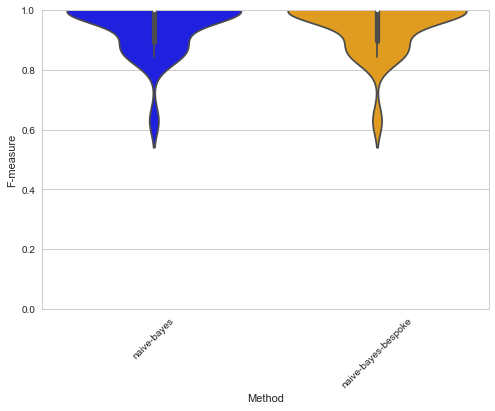

## gg_13_8_otus_amplicon level 5

Method                        Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.98             0.749161   
0          naive-bayes         0.001:char:8192:[8,8]:0.0             0.693234   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.844871   0.915530  0.970472   0.938064  
0              0.856382   0.884104  0.964049   0.916698

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -2.404844  0.023305  0.023305

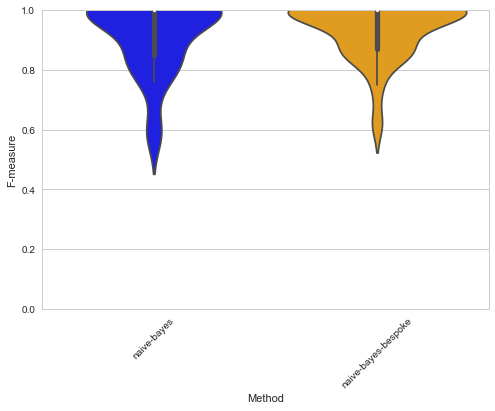

## gg_13_8_otus_amplicon level 6

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.5             0.786137   
0          naive-bayes      0.001:char:8192:[32,32]:0.7             0.457871   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.817157   0.657307  0.716940   0.681433  
0              0.532879   0.729960  0.453799   0.513547

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -3.058038  0.004981  0.004981

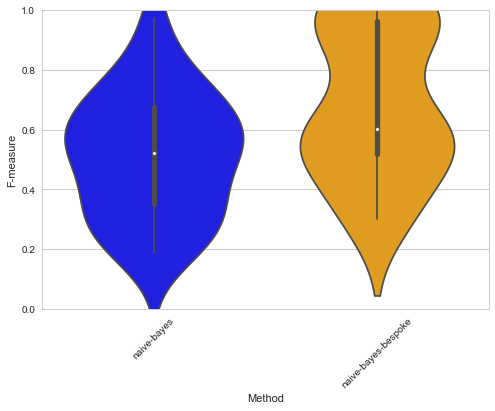

## gg_13_8_otus_full level 4

Method                        Parameters  Taxon Accuracy Rate  \
0          naive-bayes         0.001:char:8192:[8,8]:0.5             0.751394   
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.94             0.784377   

   Taxon Detection Rate  Precision    Recall  F-measure  
0              0.906435   0.920273  0.995307   0.950008  
1              0.897704   0.918849  0.991584   0.947612

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke  1.129515  0.268616  0.268616

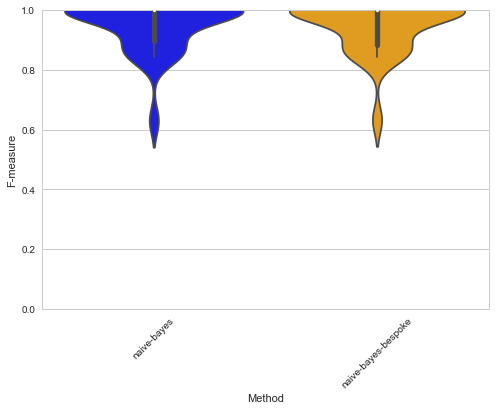

## gg_13_8_otus_full level 5

Method                        Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.94             0.779647   
0          naive-bayes         0.001:char:8192:[8,8]:0.0             0.720339   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.835688   0.919316  0.961866   0.936488  
0              0.853697   0.888081  0.968551   0.920982

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -1.933101  0.063774  0.063774

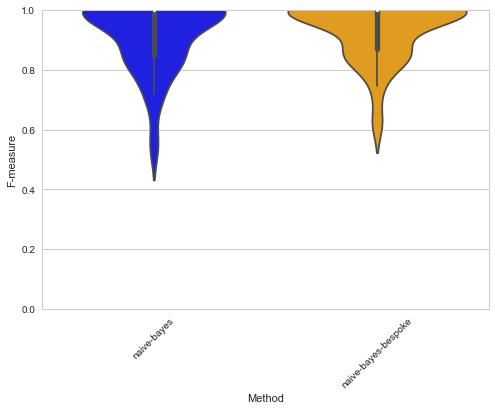

## gg_13_8_otus_full level 6

Method                       Parameters  Taxon Accuracy Rate  \
0          naive-bayes        0.001:char:8192:[7,7]:0.0             0.525379   
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.9             0.744191   

   Taxon Detection Rate  Precision    Recall  F-measure  
0              0.615232   0.687971  0.748683   0.712371  
1              0.744584   0.847492  0.582073   0.657259

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke  1.080817  0.289338  0.289338

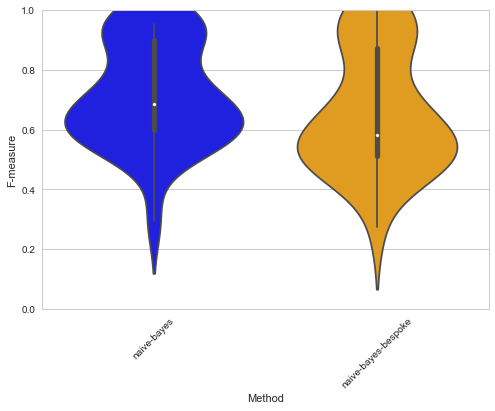

## unite_20.11.2016_clean_full level 4

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.5             0.803998   
0          naive-bayes        0.001:char:8192:[6,6]:0.7             0.768082   

   Taxon Detection Rate  Precision   Recall  F-measure  
1              0.645609   0.900767  1.00000   0.941572  
0              0.628659   0.895223  0.95912   0.924637

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -2.377085  0.020769  0.020769

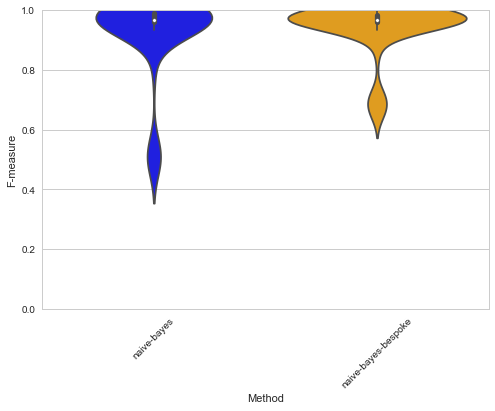

## unite_20.11.2016_clean_full level 5

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.5             0.805223   
0          naive-bayes        0.001:char:8192:[7,7]:0.0             0.768887   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.645609   0.900767  1.000000   0.941572  
0              0.617874   0.885627  0.971071   0.921707

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -2.545216  0.013603  0.013603

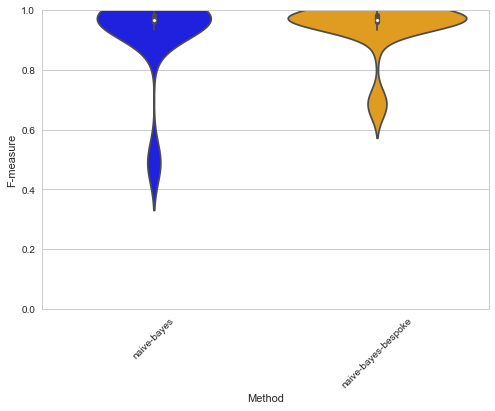

## unite_20.11.2016_clean_full level 6

Method                        Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.98             0.659270   
0          naive-bayes       0.001:char:8192:[16,16]:0.7             0.631612   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.539676   0.901408  0.928814   0.914535  
0              0.514831   0.862748  0.913333   0.886934

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -3.520812  0.000845  0.000845

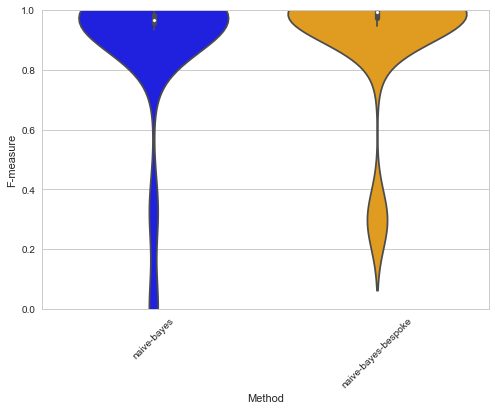

In [40]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="F-measure",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## gg_13_8_otus_amplicon level 6

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0             0.798563   
0          naive-bayes        0.001:char:8192:[6,6]:0.0             0.539866   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.819141   0.655902  0.716940   0.680540  
0              0.644493   0.440575  0.499874   0.464532

stat             P         FDR P
Method A    Method B                                                  
naive-bayes naive-bayes-bespoke -14.236611  4.525217e-14  4.525217e-14

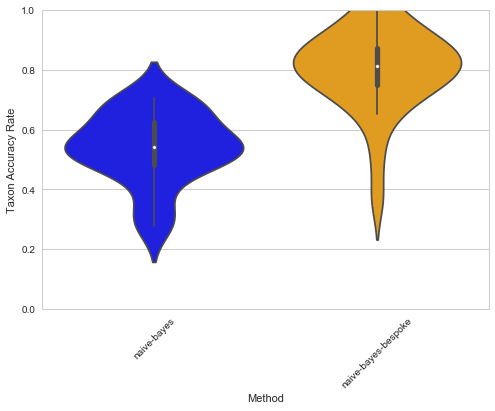

## gg_13_8_otus_full level 6

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0             0.835305   
0          naive-bayes        0.001:char:8192:[8,8]:0.0             0.547429   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.817416   0.568522  0.625709   0.591605  
0              0.624963   0.611265  0.673986   0.636709

stat             P         FDR P
Method A    Method B                                                  
naive-bayes naive-bayes-bespoke -18.900787  4.248286e-17  4.248286e-17

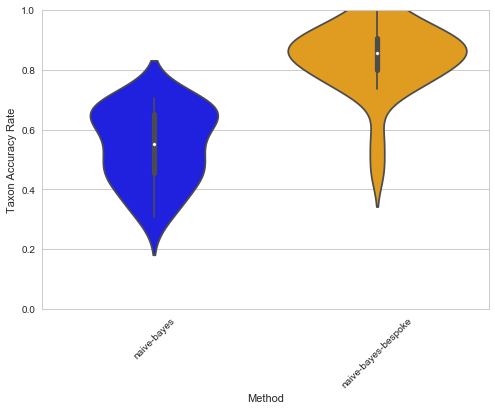

## unite_20.11.2016_clean_full level 6

Method                       Parameters  Taxon Accuracy Rate  \
1  naive-bayes-bespoke  0.001:prior:char:8192:[8,8]:0.0             0.680012   
0          naive-bayes      0.001:char:8192:[16,16]:0.7             0.631612   

   Taxon Detection Rate  Precision    Recall  F-measure  
1              0.569337   0.872185  0.946073   0.904281  
0              0.514831   0.862748  0.913333   0.886934

stat         P     FDR P
Method A    Method B                                         
naive-bayes naive-bayes-bespoke -2.600238  0.011798  0.011798

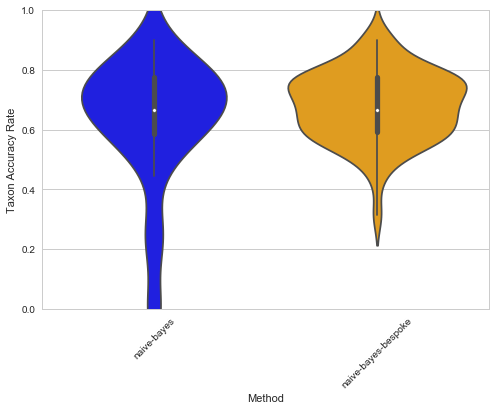

In [41]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="Taxon Accuracy Rate",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

__*Note: if you have added additional methods and are attempting to recompute results, set force=True.*__


In [ ]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, force=False)

Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

__*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, make sure you are viewing this notebook in [nbviewer](http://nbviewer.jupyter.org/). (if viewing on GitHub, just copy the URL and paste into the search bar in nbviewer.)*__

In [195]:
table = join(expected_results_dir, 'mock-18', 'gg_13_8_otus', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

R =  0.107665960452 ; P =  0.02


/Users/nbokulich/miniconda3/envs/q2-test/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.425058725719815 and the largest is 4.417440878355716.
  RuntimeWarning


Loading BokehJS ...

You can also view all beta diversity plots with a single command, ``batch_beta_diversity()``, but we will only show single dataset examples in these example notebooks.

### Average dissimilarity between expected results and observed results for each method 


As we already discussed, PCoA plots are good for a qualitative overview, but don't offer much in the way of quantitative comparison. Instead, we can directly compare the Bray-Curtis dissimilarity between methods, and utilize pairwise Mann-Whitney U tests to determine precisely which methods perform better (**lower dissimilarity = more accurate classification**). In the cell below, we will use distance comparisons to determine:

    1) Whether the dissimilarity between taxonomic assignment with different parameters of the same method is greater or less than the dissimilarity between taxonomic assignments with different methods, including the expected composition.
    2) which method (averaged across all configurations) most closely reproduces the expected composition.
    
You can generate boxplots for individual datasets one-by-one with ``per_method_boxplots()``, or for all datasets individually with ``fastlane_boxplots()``. However, here we are most interested in the average performance of methods across each dataset.

The command below violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

## gg_13_8_otus

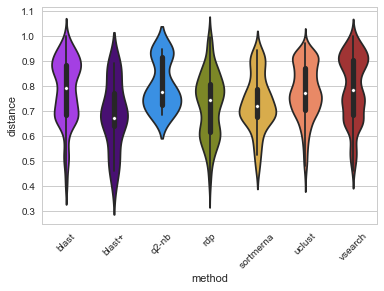

method A   method B             P
0      blast+      blast  4.613902e-06
1      blast+      q2-nb  7.597099e-01
2      blast+        rdp  1.509068e-08
3      blast+  sortmerna  1.270810e-05
4      blast+     uclust  8.736689e-01
5      blast+    vsearch  7.519476e-01
6       blast      q2-nb  1.313426e-04
7       blast        rdp  2.478060e-01
8       blast  sortmerna  7.161906e-02
9       blast     uclust  1.421662e-07
10      blast    vsearch  6.293324e-07
11      q2-nb        rdp  2.729586e-03
12      q2-nb  sortmerna  2.729586e-03
13      q2-nb     uclust  6.607385e-01
14      q2-nb    vsearch  8.736689e-01
15        rdp  sortmerna  8.736689e-01
16        rdp     uclust  1.287590e-09
17        rdp    vsearch  1.779610e-11
18  sortmerna     uclust  2.166953e-06
19  sortmerna    vsearch  1.845250e-07
20     uclust    vsearch  4.496220e-01

## unite_20.11.2016_clean_fullITS

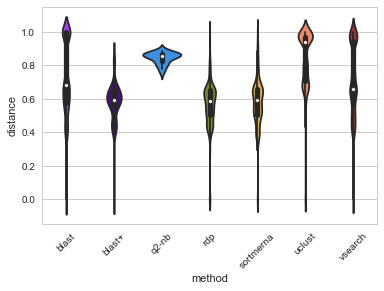

method A   method B         P
0      blast+      blast  0.000000
1      blast+      q2-nb  0.013377
2      blast+        rdp  0.000000
3      blast+  sortmerna  0.000000
4      blast+     uclust  0.000000
5      blast+    vsearch  0.642323
6       blast      q2-nb  0.000000
7       blast        rdp  0.658687
8       blast  sortmerna  0.737130
9       blast     uclust  0.000000
10      blast    vsearch  0.000000
11      q2-nb        rdp  0.000000
12      q2-nb  sortmerna  0.000000
13      q2-nb     uclust  0.794764
14      q2-nb    vsearch  0.005153
15        rdp  sortmerna  0.021680
16        rdp     uclust  0.000000
17        rdp    vsearch  0.000000
18  sortmerna     uclust  0.000000
19  sortmerna    vsearch  0.000000
20     uclust    vsearch  0.000000

None

In [196]:
results = average_distance_boxplots(expected_results_dir, paired=False,
                                    use_best=False, color_pallette=color_pallette)
display(results)

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

## gg_13_8_otus

method               params
0     blast+     0.001:1:0.99:0.8
1      blast                 1000
2      q2-nb                  0.0
3        rdp                  0.3
4  sortmerna  0.51:0.99:1:0.9:1.0
5     uclust           0.76:0.9:1
6    vsearch          1:0.99:0.99

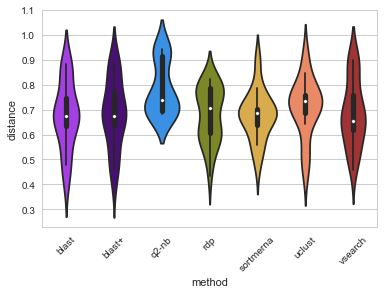

method A   method B         P
0      blast+      blast  0.288080
1      blast+      q2-nb  1.000000
2      blast+        rdp  1.000000
3      blast+  sortmerna  1.000000
4      blast+     uclust  0.431959
5      blast+    vsearch  0.836601
6       blast      q2-nb  1.000000
7       blast        rdp  0.999999
8       blast  sortmerna  0.999999
9       blast     uclust  0.754548
10      blast    vsearch  0.999999
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  0.596355
17        rdp    vsearch  0.999998
18  sortmerna     uclust  0.480903
19  sortmerna    vsearch  0.999998
20     uclust    vsearch  0.762150

## unite_20.11.2016_clean_fullITS

method              params
0     blast+   0.001:1:0.99:0.99
1      blast                1000
2      q2-nb                 0.0
3        rdp                 0.3
4  sortmerna  1.0:0.99:5:0.9:1.0
5     uclust           1.0:0.9:1
6    vsearch         1:0.99:0.99

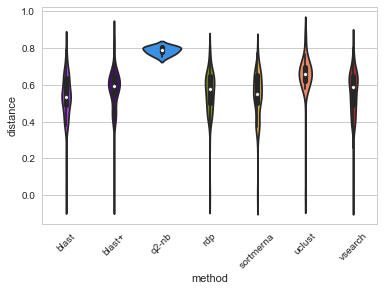

method A   method B             P
0      blast+      blast  0.000000e+00
1      blast+      q2-nb  1.000000e+00
2      blast+        rdp  0.000000e+00
3      blast+  sortmerna  3.057254e-02
4      blast+     uclust  0.000000e+00
5      blast+    vsearch  4.109293e-07
6       blast      q2-nb  1.000000e+00
7       blast        rdp  3.491831e-07
8       blast  sortmerna  4.263256e-14
9       blast     uclust  2.275840e-10
10      blast    vsearch  3.768143e-08
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.676176e-05
16        rdp     uclust  1.998401e-15
17        rdp    vsearch  8.844002e-02
18  sortmerna     uclust  3.019807e-14
19  sortmerna    vsearch  5.078448e-03
20     uclust    vsearch  4.996004e-14

In [198]:
results = average_distance_boxplots(expected_results_dir,
                                    color_pallette=color_pallette)
results